---
# **Classification of Biomedical Texts with Deep Learning: LSTM, GRU, and Soft-Attention**

---

Advancements in disease prediction and medical knowledge extraction increasingly rely on processing vast amounts of biomedical literature. Scientific texts from sources like PubMed contain rich information on diseases, treatments, and biomedical mechanisms, but their unstructured nature and domain-specific terminology pose significant challenges for automated classification.

Recurrent Neural Networks (RNNs), particularly Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU), have been widely used to capture temporal and sequential dependencies in text. However, these models face limitations in representing complex relationships within the language of scientific texts. Attention-based models, such as those incorporating self-attention mechanisms, offer a compelling alternative by allowing the model to focus on the most relevant parts of the text contextually.

This work explores how LSTM, GRU, and self-attention models can enhance classification performance by extracting temporal and semantic patterns from biomedical literature, particularly in identifying disease categories from PubMed articles.

## **Data Description**

To evaluate these models, we use two datasets derived from PubMed, each designed for disease classification:

1. **Binary-Class Dataset**: This dataset contains biomedical texts that are classified into two broad categories: malaria-related articles and other parasitic diseases.
   
2. **Multiclass Dataset**: This dataset extends the binary-class task, categorizing articles into nine disease classes, spanning both infectious and non-infectious diseases.

The task is to classify these texts into the appropriate disease category based on their content. The datasets include a variety of articles from research, clinical trials, scientific reviews, and epidemiological studies.

### **Dataset Details**

#### Binary-Class Dataset
- **Number of samples**: 20,000 articles
    - **Malaria**: 10,000 articles
    - **Other Parasitic Diseases**: 10,000 articles
- **Task**: Classify the articles into **Malaria** or **Other Diseases**.

Note: The dataset is **intentionally imbalanced** toward class 0 (Other Diseases) due to the broader nature of non-malaria literature. Class balancing techniques (e.g., undersampling, oversampling, weighted loss) may be needed during model training.

#### Multiclass Dataset
- **Number of samples**: 42,879 articles
    - **Infectious Diseases**: 16,000 articles (including Tuberculosis, Cholera, Leprosy, Ebola)
    - **Non-infectious Diseases**: 26,879 articles (including Leukemia, Asthma, Parkinson, Lupus, Cystic Fibrosis)
- **Task**: Classify the articles into one of the **nine disease classes**.

### **Disease Classes in the Binary-Class Dataset**

| Class                      | Label | Description                                                                 |
|----------------------------|-------|-----------------------------------------------------------------------------|
| Malaria                    | 1     | Articles related to **malaria or Plasmodium infections**                    |
| Other Parasitic Diseases   | 0     | Articles on protozoa, helminths, or ectoparasites (e.g., leishmaniasis)     |
| Other Diseases             | 0     | Biomedical literature not associated with malaria or parasitic infections   |

### **Disease Classes in the Multiclass Dataset**

The multiclass dataset categorizes biomedical articles into **nine distinct disease classes**. These classes are divided into two broad categories: **infectious diseases** and **non-infectious diseases**.

| Class | Disease           | Type             |
|-------|-------------------|------------------|
| 0     | Tuberculosis      | Infectious       |
| 1     | Cholera           | Infectious       |
| 2     | Leprosy           | Infectious       |
| 3     | Ebola             | Infectious       |
| 4     | Leukemia          | Non-infectious (Cancer)       |
| 5     | Asthma            | Non-infectious (Chronic Inflammatory) |
| 6     | Parkinson         | Non-infectious (Neurodegenerative)   |
| 7     | Lupus             | Non-infectious (Autoimmune)  |
| 8     | Cystic Fibrosis   | Non-infectious (Genetic)     |

Note: **Infectious diseases** are linked to external pathogens, whereas **non-infectious diseases** are typically caused by internal factors, such as chronic, autoimmune, or genetic conditions.

## **Model Implementation**

### Word and Contextual Embeddings

To enhance the representation of biomedical text data, we employ a combination of static and contextual embeddings:

- **GloVe 300d**: A pre-trained word embedding model that captures semantic relationships between words.
- **PubMedBERT**: A contextualized transformer-based model specifically trained on biomedical literature, allowing for a deeper understanding of domain-specific terminology.

### LSTM and GRU

LSTM and GRU architectures are implemented to analyze the sequential nature of biomedical abstracts and article excerpts. These models effectively capture long-term dependencies in the text, enabling more accurate classification of disease-related literature.

### Bahdanau Attention Mechanism

To further improve performance, a **Bahdanau attention mechanism** is integrated. Unlike LSTM/GRU, which process text sequentially, Bahdanau attention allows the model to dynamically weigh the importance of different parts of the input by learning a set of attention scores. This enables the model to focus on the most relevant parts of the input sequence, improving both interpretability and accuracy, particularly in longer or more complex texts. The attention mechanism provides a way to capture dependencies between words regardless of their distance in the sequence, ensuring that the model can better understand the relationships and context within the text.


In [1]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 36.4 MB/s eta 0:00:00


---
# 0. **Understanding the Data: Preprocessing**

---


In [2]:
import time
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter

from Bio import Entrez
from Bio import Medline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
import seaborn as sns
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
from torch.nn.utils.rnn import pad_sequence

from tqdm import tqdm
import wandb

In [3]:
# To ensure reproducibility of the results
SEED = 200
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
Entrez.email = "etowilfried1@gmail.com"

In [ ]:
def search_pubmed(query, retmax=15000):
    """Search PubMed for a given query."""
    handle = Entrez.esearch(db="pubmed", term=query, retmax=retmax)
    record = Entrez.read(handle)
    handle.close()
    return record["IdList"]

def fetch_abstracts(id_list):
    """
    Fetch abstracts from PubMed using a list of IDs and show progress using tqdm.
    """
    handle = Entrez.efetch(db="pubmed", id=",".join(id_list), rettype="medline", retmode="text")
    records = Medline.parse(handle)  # Iterator for parsing records
    abstracts = []

    # Wrap the records iterator with tqdm for the progress bar
    for record in tqdm(records, desc="Fetching PubMed abstracts", unit="record", total=len(id_list)):
        abstracts.append({
            "PMID": record.get("PMID", ""),
            "Title": record.get("TI", ""),
            "Abstract": record.get("AB", ""),
            "Keywords": record.get("OT", []),
            "PublicationYear": record.get("DP", "").split()[0],
            "MeSH_Terms": record.get("MH", []),
        })

    handle.close()
    return abstracts

def clean_text(text):
    """Clean text by removing special characters except mathematical symbols like >, <, , and =."""
    text = re.sub(r'[^\w\s><=,%]', ' ', text)  # Keep words, spaces, and >, <, =
    text = text.lower().strip()  # Convert to lowercase and strip spaces
    return text

In [ ]:
malaria_query = '("malaria" OR "Plasmodium" OR "malarial infection") AND (1950:2024[DP])'
parasitic_query = '"parasitic diseases" AND (1950:2024[DP])'
other_diseases_query = '"disease" NOT "malaria" AND NOT "parasitic diseases" AND (1950:2024[DP])'

malaria_ids = search_pubmed(malaria_query)
parasitic_ids = search_pubmed(parasitic_query)
other_diseases_ids = search_pubmed(other_diseases_query)

---
###  Dataset Description: Binary Classification (Malaria vs. Non-Malaria)

---
The first part is devoted to the binary classification.
Here the dataset is built for a **binary classification task**: distinguishing **malaria-related articles** from other biomedical literature, including other parasitic diseases and unrelated diseases.


The dataset contains the following number of samples:

- **Malaria-related articles**: 9,999 samples
- **Other parasitic diseases**: 9,999 samples
- **Other diseases**: 8,993 samples

---




#### Feature Analysis

####a. PMID (PubMed ID):

Type: Unique identifier (categorical).
Use: Serves as a reference for traceability but does not contribute to the predictive modeling.

####b. Title:

Type: Short text (string).
Use: Contains concise summaries of the study, which can be useful for keyword extraction or topic modeling.

####c. Abstract:

Type: Long text (string).
Use: Main source of clinical information (e.g., symptoms, risk factors, diagnostics).

####d. Keywords:

Type: List of terms (categorical).
Use: Highlights the primary topics of the study; can assist in feature engineering and labeling.

####d. PublicationYear:

Type: Numerical (integer).
Use: Indicates temporal trends; older studies may differ in terminology or context from newer studies.

####e. MeSH_Terms (Medical Subject Headings):

Type: List of terms (categorical).
Use: Structured and controlled vocabulary for categorizing medical content; useful for identifying clinical features or context.

####e. Label:

Type: Categorical (integer or string).
Use: Target variable for supervised learning; indicates whether the abstract pertains to malaria, other parasitic diseases, or other diseases.

In [ ]:
# Fetch abstracts for each query
malaria_data = fetch_abstracts(malaria_ids)
parasitic_data = fetch_abstracts(parasitic_ids)
other_diseases_data = fetch_abstracts(other_diseases_ids)

malaria_df = pd.DataFrame(malaria_data)
parasitic_df = pd.DataFrame(parasitic_data)
other_diseases_df = pd.DataFrame(other_diseases_data)

malaria_df.to_csv("malaria_data.csv", index=False)
parasitic_df.to_csv("parasitic_data.csv", index=False)
other_diseases_df.to_csv("other_diseases_data.csv", index=False)

malaria_df["Cleaned_Abstract"] = malaria_df["Abstract"].apply(clean_text)
parasitic_df["Cleaned_Abstract"] = parasitic_df["Abstract"].apply(clean_text)
other_diseases_df["Cleaned_Abstract"] = other_diseases_df["Abstract"].apply(clean_text)

malaria_df["Label"] = 1
parasitic_df["Label"] = 0
other_diseases_df["Label"] = 0

combined_df = pd.concat([malaria_df, parasitic_df, other_diseases_df], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

Fetching PubMed abstracts: 100%|██████████| 8993/8993 [00:50<00:00, 179.37record/s]


In [ ]:
combined_df.to_csv("/content/binary_diseases_dataset.csv", index=False)

In [ ]:
def count_words_with_progress(df, column_name):
    word_counts = []
    for text in tqdm(df[column_name], desc="Counting Words"):
        # Split the text into words and count them
        word_count = len(str(text).split())
        word_counts.append(word_count)
    return word_counts

combined_df['Word_Count'] = count_words_with_progress(combined_df, 'Cleaned_Abstract')

Counting Words: 100%|██████████| 28991/28991 [00:01<00:00, 28423.11it/s]


In [ ]:
combined_df.tail(3)

,PMID,Title,Abstract,Keywords,PublicationYear,MeSH_Terms,Cleaned_Abstract,Label,Word_Count
28988,39497850,Ubiquitin-proteasome system in Plasmodium: a p...,BACKGROUND: Malaria is a devasting parasitic d...,"[antimalarial resistance, artemisinin, plasmod...",2024,[],background malaria is a devasting parasitic d...,1,277
28989,32426217,The Future of Telehealth in Allergy and Immuno...,With emerging interest in the use of telemedic...,"[Education, Fellowship, Mentoring, Telemedicin...",2020,"[*COVID-19, Fellowships and Scholarships, Huma...",with emerging interest in the use of telemedic...,0,171
28990,28555175,MALDI-TOF MS Profiling-Advances in Species Ide...,"Invertebrate pests and parasites of humans, an...","[MALDI MS typing, MALDI TOF MS, intact protein...",2017,"[Animals, Clinical Laboratory Techniques/metho...","invertebrate pests and parasites of humans, an...",0,139


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/binary_diseases_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28991 entries, 0 to 28990
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              28991 non-null  int64 
 1   Title             28988 non-null  object
 2   Abstract          26886 non-null  object
 3   Keywords          28991 non-null  object
 4   PublicationYear   28991 non-null  object
 5   MeSH_Terms        28991 non-null  object
 6   Cleaned_Abstract  26886 non-null  object
 7   Label             28991 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 1.8+ MB


In [ ]:
class_counts = data['Label'].value_counts()
print(class_counts)

Label
0    18992
1     9999
Name: count, dtype: int64


In [ ]:
data = data.dropna()
class_counts = data['Label'].value_counts()
print(class_counts)

Label
0    17455
1     9428
Name: count, dtype: int64


In [ ]:
data.head(3)

,PMID,Title,Abstract,Keywords,PublicationYear,MeSH_Terms,Cleaned_Abstract,Label
0,38762448,"Characteristics of the Western Province, Zambi...",BACKGROUND: The attractive targeted sugar bait...,"['Attractive targeted sugar bait', 'Malaria', ...",2024,"['Zambia', '*Mosquito Control/methods/statisti...",background the attractive targeted sugar bait...,1
1,36827266,Optimizing hierarchical tree dissection parame...,Hierarchical clustering of pathogen genotypes ...,[],2023,"['Cluster Analysis', '*Disease Outbreaks', '*C...",hierarchical clustering of pathogen genotypes ...,0
2,32061795,Machine learning in the clinical microbiology ...,BACKGROUND: Machine learning (ML) allows the a...,"['Artificial intelligence', 'Clinical microbio...",2020,"['Bacterial Infections/diagnosis/therapy', '*C...",background machine learning ml allows the a...,0


In [ ]:
data.tail(3)

,PMID,Title,Abstract,Keywords,PublicationYear,MeSH_Terms,Cleaned_Abstract,Label
28988,39497850,Ubiquitin-proteasome system in Plasmodium: a p...,BACKGROUND: Malaria is a devasting parasitic d...,"['antimalarial resistance', 'artemisinin', 'pl...",2024,[],background malaria is a devasting parasitic d...,1
28989,32426217,The Future of Telehealth in Allergy and Immuno...,With emerging interest in the use of telemedic...,"['Education', 'Fellowship', 'Mentoring', 'Tele...",2020,"['*COVID-19', 'Fellowships and Scholarships', ...",with emerging interest in the use of telemedic...,0
28990,28555175,MALDI-TOF MS Profiling-Advances in Species Ide...,"Invertebrate pests and parasites of humans, an...","['MALDI MS typing', 'MALDI TOF MS', 'intact pr...",2017,"['Animals', 'Clinical Laboratory Techniques/me...","invertebrate pests and parasites of humans, an...",0


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

---
## Extract Relevant Words for Each Abstract (with TF-IDF)
---

Stopwords removal:

Stopwords are those English words
 that do not add any meaning to a sentence. So these can be
 removed by stopwords removal without affecting the mean
ing of a sentence. The removal of stop-words increases the
 models performances and decreases the complexity of input
 feature.

 Removing numbers during preprocessing may not be a good idea because numbers (like temperature, age, blood pressure, etc.) can be critical for classification.

In [ ]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    words = text.split()  # Tokenize
    stop_words = set(stopwords.words('english'))  # Load stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

tqdm.pandas(desc="Preprocessing Text")
data['Cleaned_Abstract'] = data['Cleaned_Abstract'].astype(str).progress_apply(preprocess_text)
data.to_csv("binary_diseases_dataset.csv", index=False)

Preprocessing Text: 100%|██████████| 26883/26883 [01:03<00:00, 423.36it/s]


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_sparse = vectorizer.fit_transform(data['Cleaned_Abstract'])

tfidf_df = pd.DataFrame.sparse.from_spmatrix(X_sparse, columns=vectorizer.get_feature_names_out())

top_words_per_abstract = np.argsort(-X_sparse.toarray(), axis=1)[:, :50]
feature_names = np.array(vectorizer.get_feature_names_out())
top_words_per_abstract = [[feature_names[idx] for idx in row] for row in top_words_per_abstract]

data['Top_Relevant_Words'] = top_words_per_abstract

# Display results
print(data[['PMID', 'Title', 'Top_Relevant_Words']].head())

       PMID                                              Title  \
0  38762448  Characteristics of the Western Province, Zambi...   
1  36827266  Optimizing hierarchical tree dissection parame...   
2  32061795  Machine learning in the clinical microbiology ...   
3  22319130  Sea lice as a density-dependent constraint to ...   
4  11429515  Intestinal and systemic infection, HIV, and mo...   

                                  Top_Relevant_Words  
0  [trial, site, zambia, sugar, atsb, malaria, cl...  
1  [tree, dissection, value, epidemiologic, param...  
2  [ml, clinical, data, system, targeted, digital...  
3  [salmonid, louse, farmed, sea, density, farm, ...  
4  [hiv, child, seronegative, seropositive, malnu...  


In [ ]:
relevant_words_by_class = {}

for label in data['Label'].unique():
    # Filter rows for the given class label
    class_data = data[data['Label'] == label]
    class_top_words = class_data['Top_Relevant_Words'].explode().value_counts()
    relevant_words_by_class[label] = class_top_words

for label, words in relevant_words_by_class.items():
    print(f"Top relevant words for class {label}:")
    print(words.head(10))  # Show top 10 most relevant words
    print("\n")

Top relevant words for class 1:
Top_Relevant_Words
malaria       4225
falciparum    1561
plasmodium    1555
parasite      1502
study         1319
mosquito      1166
drug          1136
infection     1066
blood         1018
health         996
Name: count, dtype: int64


Top relevant words for class 0:
Top_Relevant_Words
infection    3876
disease      3747
parasite     2629
parasitic    1978
patient      1971
specie       1904
zika         1838
host         1823
human        1780
control      1735
Name: count, dtype: int64




In [ ]:
def generate_wordcloud(word_counts, class_label, ax):
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_counts)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Word Cloud for Class {class_label}')

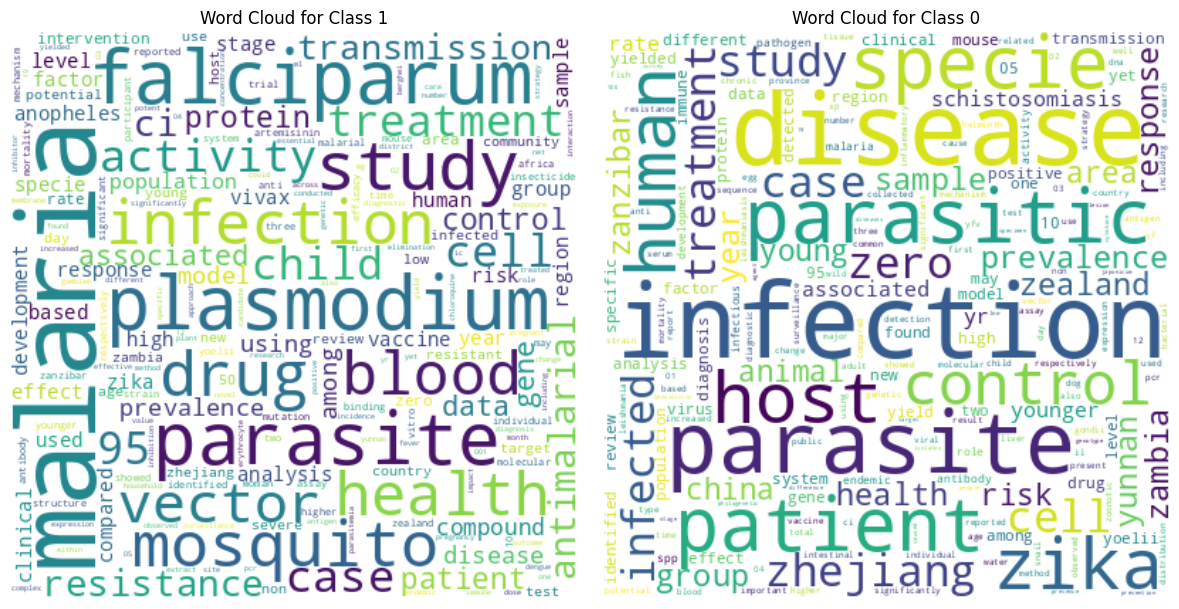

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for idx, (label, words) in enumerate(relevant_words_by_class.items()):
    generate_wordcloud(words, label, axes[idx])

plt.tight_layout()
plt.show()

Using only relevant words for solving the classification problem can introduce bias and impact model performance in several ways. Here’s why and how to approach it carefully:

- Loss of Context & Semantic Meaning
By selecting only the most relevant words (e.g., top 500 TF-IDF words), you might remove crucial contextual information.
Sequence models like GRU and LSTM rely on word order and dependencies. If words are extracted without their original sequence, models may struggle to capture relationships between terms;
- Reduced Generalization Ability
Important but low-frequency words may be excluded, leading to poor generalization on unseen data.
Medical terms often appear in different contexts, and missing certain words could impact performance;
- Bias Toward Frequent Words
TF-IDF favors words that appear frequently but uniquely. However, in medical datasets, some rare but critical words might be ignored.
This could skew the model’s learning process, leading to overfitting to certain patterns.

---
#1. **Data Preparation**

---

Prepare the Data

- Split the dataset into training (70%), validation (15%), and test sets (15%).

- Tokenize the text and convert it into numerical sequences.

- Pad sequences to ensure uniform input length.
Encode the labels.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/binary_diseases_dataset.csv')
data.tail(3)

,PMID,Title,Abstract,Keywords,PublicationYear,MeSH_Terms,Cleaned_Abstract,Label
26880,39497850,Ubiquitin-proteasome system in Plasmodium: a p...,BACKGROUND: Malaria is a devasting parasitic d...,"['antimalarial resistance', 'artemisinin', 'pl...",2024,[],background malaria devasting parasitic disease...,1
26881,32426217,The Future of Telehealth in Allergy and Immuno...,With emerging interest in the use of telemedic...,"['Education', 'Fellowship', 'Mentoring', 'Tele...",2020,"['*COVID-19', 'Fellowships and Scholarships', ...","emerging interest use telemedicine, allergy im...",0
26882,28555175,MALDI-TOF MS Profiling-Advances in Species Ide...,"Invertebrate pests and parasites of humans, an...","['MALDI MS typing', 'MALDI TOF MS', 'intact pr...",2017,"['Animals', 'Clinical Laboratory Techniques/me...","invertebrate pest parasite humans, animals, pl...",0


In [6]:
# ========== Set device ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X = data["Cleaned_Abstract"].values
y = data["Label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Using device: cuda
Training set: 18818 samples
Validation set: 4032 samples
Test set: 4033 samples


In [7]:
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

all_tokens = [token for text in X_train for token in tokenize(text)]
vocab = Counter(all_tokens)
filtered_vocab = {word: freq for word, freq in vocab.items() if freq >= 2}

VOCAB_SIZE = 40000
sorted_filtered_vocab = dict(sorted(filtered_vocab.items(), key=lambda item: item[1], reverse=True)[:VOCAB_SIZE])

word_to_index = {word: idx for idx, (word, _) in enumerate(sorted_filtered_vocab.items(), 1)}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = len(word_to_index)

index_to_word = {idx: word for word, idx in word_to_index.items()}

print(word_to_index.get("malaria"))
print(index_to_word.get(1))
print(index_to_word.get(300))
print(word_to_index.get("host"))

1
malaria
interaction
28


In [8]:
def text_to_sequence(text):
    """
    Converts a text string into a sequence of token indices based on a predefined vocabulary.

    Args:
        text (str): The input text string to be tokenized and converted into a sequence of indices.

    Returns:
        list: A list of token indices corresponding to the input text. If a token is not found in the vocabulary,
              it is replaced with the index for the "<UNK>" token.
    """
    return [word_to_index.get(token, word_to_index["<UNK>"]) for token in tokenize(text)]


def pad_to_tensor(sequences, max_len=None):
    """
    Pads a list of sequences (lists of token indices) to ensure they all have the same length, either by truncating
    or padding them with zeros. The sequences are then converted to a tensor.

    Args:
        sequences (list of list of int): A list of tokenized sequences (each sequence is a list of integers representing tokens).
        max_len (int, optional): The maximum length to which each sequence should be padded/truncated. If None, no padding is applied.

    Returns:
        torch.Tensor: A tensor containing the padded (or truncated) sequences. The tensor has shape (num_sequences, max_len).
    """
    padded_sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    if max_len:
        padded_sequences = [seq[:max_len] for seq in padded_sequences]
        padded_sequences = [
            torch.cat([seq, torch.zeros(max_len - len(seq), dtype=torch.long)], 0) if len(seq) < max_len else seq
            for seq in padded_sequences
        ]
    return torch.stack(padded_sequences)

X_train_seq = [text_to_sequence(text) for text in X_train]
X_val_seq = [text_to_sequence(text) for text in X_val]
X_test_seq = [text_to_sequence(text) for text in X_test]

max_length = 400
X_train_tensor = pad_to_tensor(X_train_seq, max_len=max_length)
X_val_tensor = pad_to_tensor(X_val_seq, max_len=max_length)
X_test_tensor = pad_to_tensor(X_test_seq, max_len=max_length)

print(f"Train Tensor Shape: {X_train_tensor.shape}")
print(f"Validation Tensor Shape: {X_val_tensor.shape}")
print(f"Test Tensor Shape: {X_test_tensor.shape}")

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

Train Tensor Shape: torch.Size([18818, 400])
Validation Tensor Shape: torch.Size([4032, 400])
Test Tensor Shape: torch.Size([4033, 400])


In [9]:
class TextDataset(Dataset):
    """
    A custom Dataset class for text data used in training and evaluation.

    Args:
        X_data (list or np.array): The input data, typically the tokenized text sequences.
        y_data (list or np.array): The labels corresponding to each input sequence.
        raw_text_data (list, optional): The original raw text data, if available. Defaults to None.

    Attributes:
        X (torch.Tensor): Tensor of input data (text sequences) in long format.
        y (torch.Tensor): Tensor of labels in float format.
        raw_text_data (list or None): Original raw text data (if provided).

    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns the input data, corresponding label, and the raw text (if available) for a given index.
    """

    def __init__(self, X_data, y_data, raw_text_data=None):
        self.X = torch.tensor(X_data, dtype=torch.long)
        self.y = torch.tensor(y_data, dtype=torch.float)
        self.raw_text_data = raw_text_data

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Retrieves the input data, corresponding label, and raw text (if available) for a given index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing:
                - input data (X[idx]): The tokenized input sequence (torch.Tensor).
                - label (y[idx]): The label corresponding to the input data (torch.Tensor).
                - raw_text (str or None): The raw text data (if available), otherwise None.
        """
        raw_text = self.raw_text_data[idx] if self.raw_text_data is not None else None
        return self.X[idx], self.y[idx], raw_text

In [10]:
batch_size = 32
train_dataset = TextDataset(X_train_tensor, y_train, X_train)
val_dataset = TextDataset(X_val_tensor, y_val, X_val)
test_dataset = TextDataset(X_test_tensor, y_test, X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Combined dataset size: {len(combined_dataset)}")

Training set size: 18818
Validation set size: 4032
Test set size: 4033
Combined dataset size: 22850


<ipython-input-9-412dfc10b1c9>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


In [11]:
VOCAB_SIZE = len(word_to_index)

class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=1, num_layers=1, dropout_prob=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.gru(embedded)
        out = self.fc(self.dropout(hidden[-1]))
        return out

class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=1, num_layers=1, dropout_prob=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.fc(self.dropout(hidden[-1]))
        return out

In [12]:
clip = 5.0

def epoch_time(start_time, end_time):
    elapsed = end_time - start_time
    return int(elapsed / 60), int(elapsed % 60)

def train_epoch(model, dataloader, optimizer, criterion, device):
    """
    Trains the model for one epoch.

    Args:
        model (torch.nn.Module): The model to be trained.
        dataloader (torch.utils.data.DataLoader): The DataLoader providing the training data.
        optimizer (torch.optim.Optimizer): The optimizer to update the model parameters.
        criterion (torch.nn.Module): The loss function used to compute the loss.
        device (torch.device): The device to run the model on (CPU or GPU).

    Returns:
        float: The average loss for the epoch.
        float: The balanced accuracy for the epoch.

    The function performs the following tasks:
        - Sets the model to training mode.
        - Loops over the batches in the DataLoader.
        - For each batch, performs the forward pass, computes the loss, performs backpropagation,
          and updates the model's weights using the optimizer.
        - Tracks the loss and predictions for calculating the balanced accuracy.
    """
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels, _ in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        preds = (torch.sigmoid(outputs) >= 0.5).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_balanced_acc

def validate_epoch(model, dataloader, criterion, device):
    """
    Validate the model for one epoch.
    Args:
        model: Model instance.
        val_loader: DataLoader for validation data.
        criterion: Loss function (CrossEntropyLoss).
        device: CPU/GPU.
    Returns:
        Average validation loss, accuracy, and F1-score.
    """

    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) >= 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds) * 100

    return epoch_loss, balanced_acc, f1

def get_hidden_states(model, dataloader, device):
    """
    This function extracts the hidden states from a model (either GRU or LSTM) for each sample in the dataloader.
    The hidden states are taken from the last time step of the sequence, which are typically used for classification tasks.

    Args:
        model: A PyTorch model that contains an embedding layer and either a GRU or LSTM layer.
        dataloader: A DataLoader containing batches of input data and their corresponding targets.
        device: The device (CPU or GPU) to run the model on.

    Returns:
        hidden_states: A numpy array containing the hidden states for each sample in the dataloader.
        labels: A numpy array containing the target labels corresponding to each input sample.
    """
    model.eval()
    hidden_states, labels = [], []

    with torch.no_grad():
        for inputs, targets, _ in dataloader:
            inputs = inputs.to(device)
            embedded = model.embedding(inputs)

            if hasattr(model, "gru"):
                output, _ = model.gru(embedded)
                state = output[:, -1, :]
            elif hasattr(model, "lstm"):
                _, (state, _) = model.lstm(embedded)
                state = state[-1]
            else:
                raise ValueError("Model must contain GRU or LSTM.")

            hidden_states.append(state.cpu().numpy())
            labels.append(targets.numpy())

    return np.concatenate(hidden_states), np.concatenate(labels)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

---
# 2. **Validation phase**

---

Training and validating model-based GRU

In [ ]:
num_epochs = 5

model = GRU_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=128,
    hidden_dim=256,
    output_dim=1,
    num_layers=1,
    dropout_prob=0.9
).to(device)

print(f"{ count_parameters(model)} model parameters")
print(model)

5416961 model parameters
GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 256, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
model.eval()

embeddings = []
labels = []

with torch.no_grad():
    for inputs, targets, _ in train_loader:
        inputs = inputs.to(device)
        embedded = model.embedding(inputs)
        embeddings.append(embedded.mean(dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())

embeddings = np.vstack(embeddings)
labels = np.array(labels)

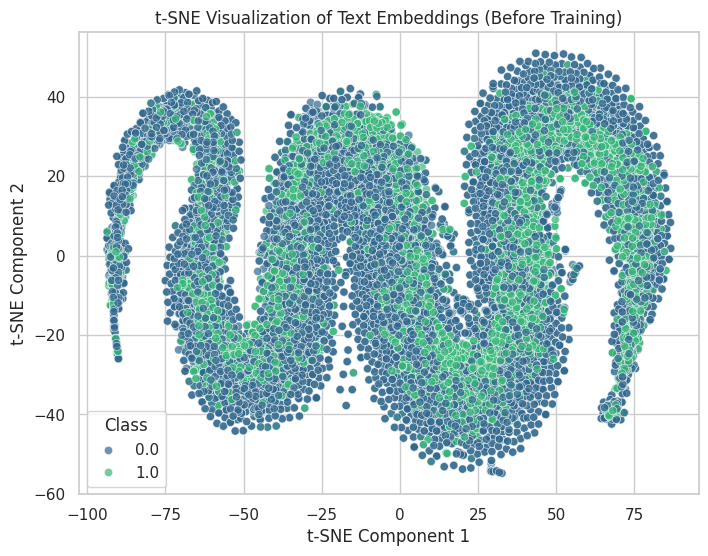

In [ ]:
# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of Text Embeddings (Before Training)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")
plt.grid(True)
plt.show()

In [ ]:
loss_function = nn.BCEWithLogitsLoss()
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_losses, val_losses = [], []
train_acsas, val_acsas = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_acsas.append(train_accuracy)

        # Validation phase
        val_loss, val_accuracy, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_acsas.append(val_accuracy)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(f"Epoch {epoch+1}/{num_epochs} - "
                             f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                             f"Train ACSA: {train_accuracy:.2%}, Val ACSA: {val_accuracy:.2%}, "
                             f"Val F1: {val_f1:.4f}, "
                             f"Time: {epoch_duration / 60:.2f} min")
        pbar.update(1)

Epoch 5/5 - Train Loss: 0.2493, Val Loss: 0.2561, Train ACSA: 91.13%, Val ACSA: 90.72%, Val F1: 87.2456, Time: 0.38 min: 100%|██████████| 5/5 [01:54<00:00, 22.80s/epoch]


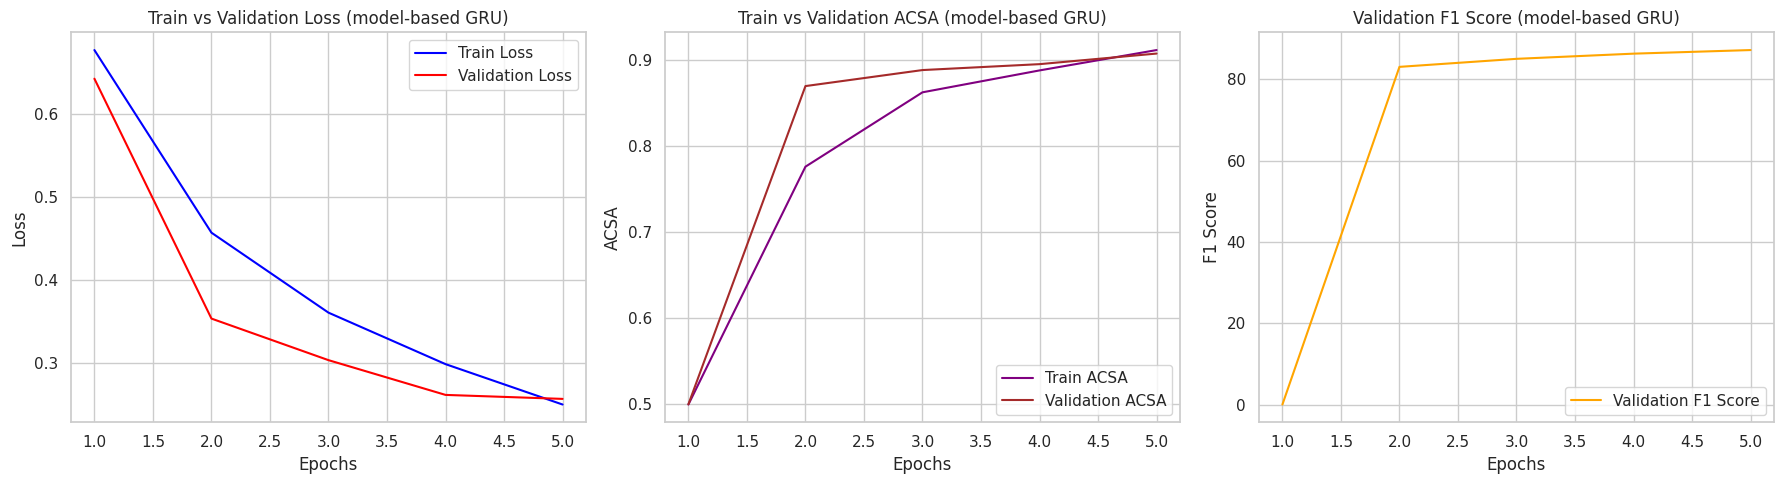

In [ ]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Train vs Validation Loss
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, label='Train Loss', color='blue', ax=axes[0])
sns.lineplot(x=range(1, num_epochs + 1), y=val_losses, label='Validation Loss', color='red', ax=axes[0])
axes[0].set_title('Train vs Validation Loss (model-based GRU)')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Train vs Validation ACSA
sns.lineplot(x=range(1, num_epochs + 1), y=train_acsas, label='Train ACSA', color='purple', ax=axes[1])
sns.lineplot(x=range(1, num_epochs + 1), y=val_acsas, label='Validation ACSA', color='brown', ax=axes[1])
axes[1].set_title('Train vs Validation ACSA (model-based GRU)')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('ACSA')
axes[1].legend()
axes[1].grid(True)

# Plot Validation F1 Score
sns.lineplot(x=range(1, num_epochs + 1), y=val_f1s, label='Validation F1 Score', color='orange', ax=axes[2])
axes[2].set_title('Validation F1 Score (model-based GRU)')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('F1 Score')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
hidden_states, labels = get_hidden_states(model, val_loader, device)
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
tsne_result = tsne.fit_transform(hidden_states)

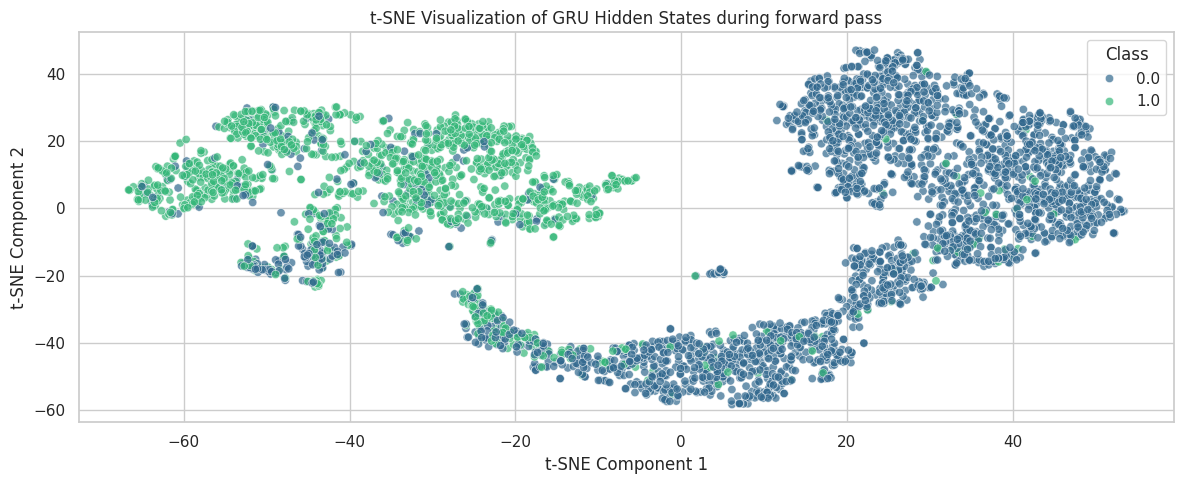

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of GRU Hidden States during forward pass")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")

plt.tight_layout()
plt.grid(True)
plt.show()

Training and validating model-based LSTM

In [ ]:
embedding_dim = 128
hidden_dim = 256
num_epochs = 10

model = LSTM_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    output_dim=1,
    num_layers=1,
    dropout_prob=0.3
).to(device)

print(f"{ count_parameters(model)} model parameters")
print(model)

5515777 model parameters
LSTM_Model(
  (embedding): Embedding(40002, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
model.eval()

embeddings = []
labels = []

with torch.no_grad():
    for inputs, targets, _ in train_loader:
        inputs = inputs.to(device)
        embedded = model.embedding(inputs)
        embeddings.append(embedded.mean(dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())

embeddings = np.vstack(embeddings)
labels = np.array(labels)

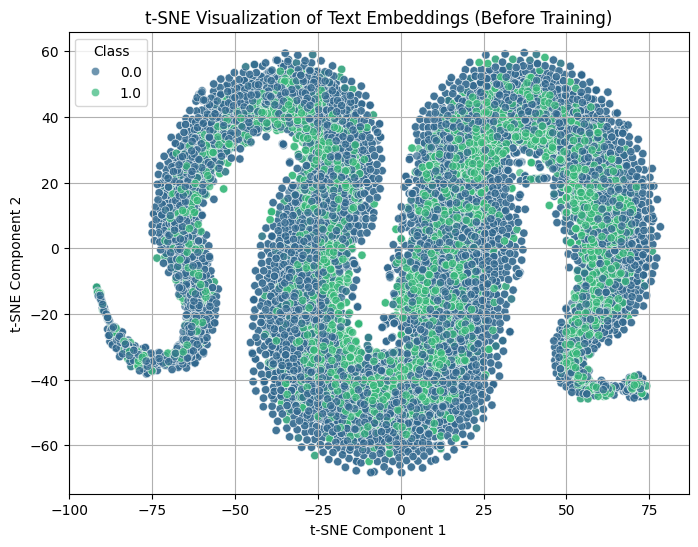

In [ ]:
# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of Text Embeddings (Before Training)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")
plt.grid(True)
plt.show()

In [ ]:
loss_function = nn.BCEWithLogitsLoss()
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_acsas, val_acsas = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_acsas.append(train_accuracy)

        # Validation phase
        val_loss, val_accuracy, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_acsas.append(val_accuracy)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(f"Epoch {epoch+1}/{num_epochs} - "
                             f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                             f"Train ACSA: {train_accuracy:.2%}, Val ACSA: {val_accuracy:.2%}, "
                             f"Val F1: {val_f1:.4f}, "
                             f"Time: {epoch_duration / 60:.2f} min")
        pbar.update(1)

Epoch 10/10 - Train Loss: 0.4090, Val Loss: 0.3156, Train ACSA: 79.42%, Val ACSA: 88.77%, Val F1: 84.3279, Time: 0.22 min: 100%|██████████| 10/10 [02:15<00:00, 13.52s/epoch]


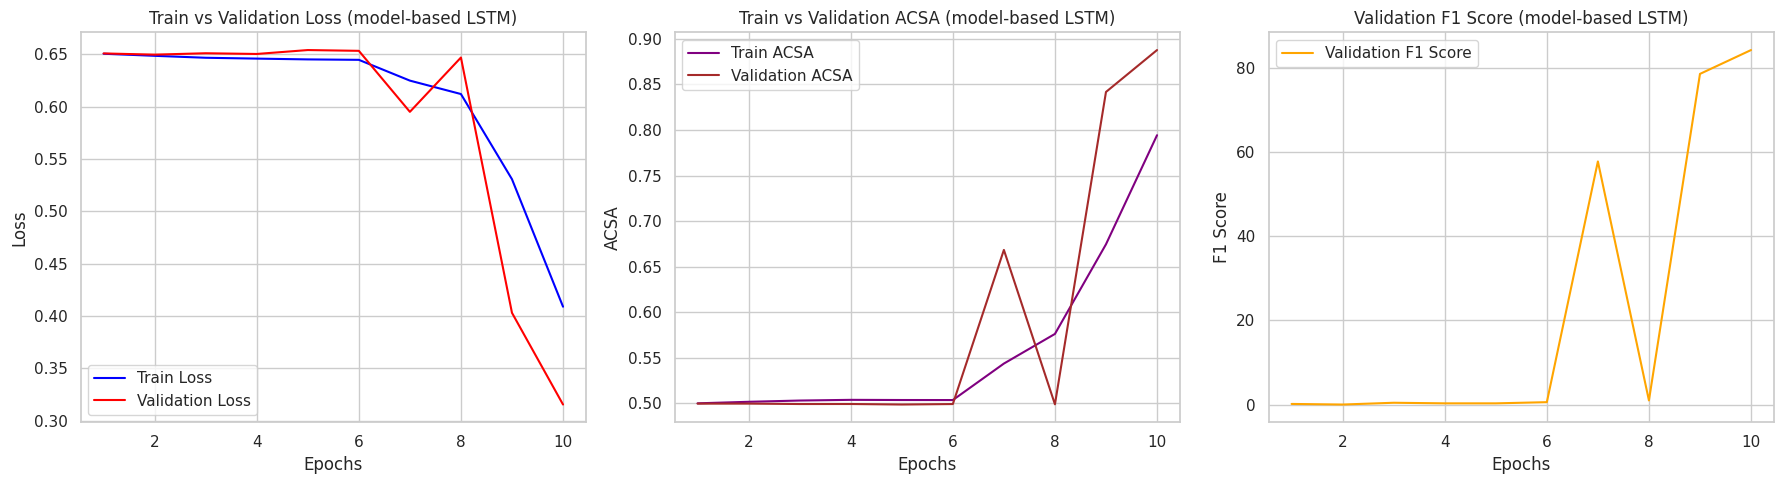

In [ ]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Train vs Validation Loss
sns.lineplot(x=range(1, num_epochs + 1), y=train_losses, label='Train Loss', color='blue', ax=axes[0])
sns.lineplot(x=range(1, num_epochs + 1), y=val_losses, label='Validation Loss', color='red', ax=axes[0])
axes[0].set_title('Train vs Validation Loss (model-based LSTM)')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Train vs Validation ACSA
sns.lineplot(x=range(1, num_epochs + 1), y=train_acsas, label='Train ACSA', color='purple', ax=axes[1])
sns.lineplot(x=range(1, num_epochs + 1), y=val_acsas, label='Validation ACSA', color='brown', ax=axes[1])
axes[1].set_title('Train vs Validation ACSA (model-based LSTM)')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('ACSA')
axes[1].legend()
axes[1].grid(True)

# Plot Validation F1 Score
sns.lineplot(x=range(1, num_epochs + 1), y=val_f1s, label='Validation F1 Score', color='orange', ax=axes[2])
axes[2].set_title('Validation F1 Score (model-based LSTM)')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('F1 Score')
axes[2].legend()
axes[2].grid(True)

# Layout adjustment and display
plt.tight_layout()
plt.show()

In [ ]:
hidden_states, labels = get_hidden_states(model, val_loader, device)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
tsne_result = tsne.fit_transform(hidden_states)

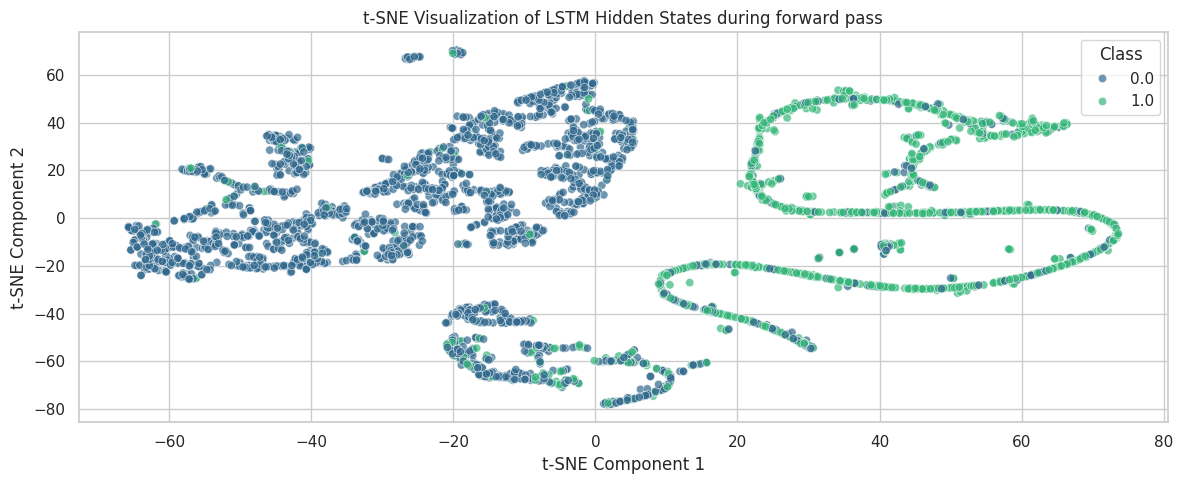

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of LSTM Hidden States during forward pass")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")

plt.tight_layout()
plt.grid(True)
plt.show()

---
#3. **Optimisation phase**

---

---
### 3.1 Model-based GRU

3.1.1 Optimizer selection

In [ ]:
loss_function = nn.BCEWithLogitsLoss()
learning_rate = 1e-3
num_epochs = 5

optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW,
}

# Loop over each optimizer
for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    # Initialize model
    model = GRU_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=128,
        hidden_dim=256,
        output_dim=1,
        num_layers=1,
        dropout_prob=0.9
    ).to(device)

    # Initialize optimizer
    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Initialize W&B
    wandb.init(
        entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_GRU_Optimizer_Comparison',
        name=f"{optimizer_name}_GRU_Run",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': optimizer_name,
            'model': 'GRU_Model',
            'embedding_dim': 128,
            'hidden_dim': 256,
            'dropout_prob': 0.9
        }
    )

    print(model)
    print(f"Total trainable parameters: {count_parameters(model)}")

    # Track metrics
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            # Train and validate
            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

            # Save results
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            # Update progress
            pbar.set_description(
                f"{optimizer_name} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            # Log to W&B
            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'epoch': epoch + 1
            })

    wandb.finish()


🔹 Training with optimizer: Adam


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 256, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5416961


Adam | Epoch 5/5 - Train Loss: 0.2477, Val Loss: 0.2448, Train ACC: 91.19%, Val ACC: 91.39%, Time: 0.42 min: 100%|██████████| 5/5 [01:59<00:00, 23.95s/epoch]


epoch,▁▃▅▆█
train_acc,▁▇▇██
train_loss,█▄▃▂▁
val_acc,▁▂▆▇█
val_f1,▁▂▆▇█
val_loss,█▇▃▂▁
epoch,5
train_acc,0.91188
train_loss,0.24771
val_acc,0.91393
val_f1,88.19113



🔹 Training with optimizer: RMSprop


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 256, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5416961


RMSprop | Epoch 5/5 - Train Loss: 0.2976, Val Loss: 0.3182, Train ACC: 89.14%, Val ACC: 89.84%, Time: 0.42 min: 100%|██████████| 5/5 [02:02<00:00, 24.46s/epoch]


epoch,▁▃▅▆█
train_acc,▁▇▆▇█
train_loss,█▄▅▃▁
val_acc,▇▇▁██
val_f1,▇▇▁██
val_loss,▃▃█▁▂
epoch,5
train_acc,0.89141
train_loss,0.2976
val_acc,0.89844
val_f1,86.21042



🔹 Training with optimizer: AdamW


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 256, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5416961


AdamW | Epoch 5/5 - Train Loss: 0.2199, Val Loss: 0.2433, Train ACC: 92.41%, Val ACC: 90.73%, Time: 0.48 min: 100%|██████████| 5/5 [02:03<00:00, 24.67s/epoch]


epoch,▁▃▅▆█
train_acc,▁▅▇██
train_loss,█▅▃▂▁
val_acc,▁████
val_f1,▁████
val_loss,█▂▁▁▁
epoch,5
train_acc,0.9241
train_loss,0.21992
val_acc,0.90727
val_f1,87.17083


3.1.2 Learning rate value selection

In [ ]:
loss_function = nn.BCEWithLogitsLoss()
num_epochs = 5
weight_decay = 1e-5
dropout_prob = 0.9

learning_rates = [1e-3, 5e-4, 1e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with learning rate: {lr}")

    # Initialize model
    model = GRU_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=128,
        hidden_dim=256,
        output_dim=1,
        num_layers=1,
        dropout_prob=dropout_prob
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Initialize W&B
    wandb.init(
        entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_GRU_LR_Tuning',
        name=f"Adam_lr_{lr}",
        config={
            'learning_rate': lr,
            'num_epochs': num_epochs,
            'optimizer': 'Adam',
            'model': 'GRU_Model',
            'embedding_dim': 128,
            'hidden_dim': 256,
            'dropout_prob': dropout_prob
        }
    )

    print(model)
    print(f"Total trainable parameters: {count_parameters(model)}")

    # Track metrics
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Adam lr={lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(
                f"Adam lr={lr} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            # Log to W&B
            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'epoch': epoch + 1
            })

    wandb.finish()


🔹 Training with learning rate: 0.001


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 256, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5416961


Adam lr=0.001 | Epoch 5/5 - Train Loss: 0.3862, Val Loss: 0.3488, Train ACC: 85.35%, Val ACC: 86.38%, Time: 0.26 min: 100%|██████████| 5/5 [01:07<00:00, 13.47s/epoch]


epoch,▁▃▅▆█
train_acc,▁▅███
train_loss,█▄▁▁▁
val_acc,▁████
val_f1,▁████
val_loss,█▁▁▁▁
epoch,5
train_acc,0.85352
train_loss,0.38625
val_acc,0.8638
val_f1,82.44111



🔹 Training with learning rate: 0.0005


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 256, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5416961


Adam lr=0.0005 | Epoch 5/5 - Train Loss: 0.3645, Val Loss: 0.3533, Train ACC: 87.39%, Val ACC: 87.24%, Time: 0.21 min: 100%|██████████| 5/5 [01:12<00:00, 14.55s/epoch]


epoch,▁▃▅▆█
train_acc,▁▁▅▇█
train_loss,██▄▂▁
val_acc,▁▁███
val_f1,▁▁███
val_loss,██▁▁▁
epoch,5
train_acc,0.87386
train_loss,0.36453
val_acc,0.87243
val_f1,83.35674



🔹 Training with learning rate: 0.0001


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 256, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5416961


Adam lr=0.0001 | Epoch 5/5 - Train Loss: 0.6524, Val Loss: 0.6490, Train ACC: 49.97%, Val ACC: 49.88%, Time: 0.22 min: 100%|██████████| 5/5 [01:05<00:00, 13.14s/epoch]


epoch,▁▃▅▆█
train_acc,▁▅▇█▅
train_loss,█▂▂▂▁
val_acc,▁▅███
val_f1,▁▄███
val_loss,█▁▄▁▁
epoch,5
train_acc,0.49973
train_loss,0.6524
val_acc,0.49882
val_f1,0.14045


3.1.3 Hidden dimension value selection

In [ ]:
hidden_dims = [100, 250, 350]

learning_rate = 1e-3
num_epochs = 5
dropout_prob = 0.9
loss_function = nn.BCEWithLogitsLoss()
weight_decay = 1e-5

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}")

    model = GRU_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=128,
        hidden_dim=hidden_dim,
        output_dim=1,
        num_layers=1,
        dropout_prob=dropout_prob
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    wandb.init(
        entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_GRU_HiddenDim_Tuning',
        name=f"GRU_hdim_{hidden_dim}",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': 'Adam',
            'hidden_dim': hidden_dim,
            'embedding_dim': 128,
            'dropout_prob': dropout_prob
        }
    )

    print(model)
    print(f"Total trainable parameters: {count_parameters(model)}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"HiddenDim: {hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            duration = end_time - start_time

            pbar.set_description(
                f"HiddenDim {hidden_dim} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"Time: {duration / 60:.2f} min"
            )
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'epoch': epoch + 1
            })

    wandb.finish()


🔹 Training with hidden_dim: 100


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 100, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
Total trainable parameters: 5189357


HiddenDim 100 | Epoch 5/5 - Train Loss: 0.3799, Val Loss: 0.3757, Train ACC: 87.00%, Val ACC: 86.72%, Time: 0.07 min: 100%|██████████| 5/5 [00:19<00:00,  3.92s/epoch]


epoch,▁▃▅▆█
train_acc,▁▁▂██
train_loss,██▇▁▁
val_acc,▁▁███
val_f1,▁▁███
val_loss,██▂▁▁
epoch,5
train_acc,0.86995
train_loss,0.37991
val_acc,0.86724
val_f1,81.86291



🔹 Training with hidden_dim: 250


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 250, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=250, out_features=1, bias=True)
)
Total trainable parameters: 5405507


HiddenDim 250 | Epoch 5/5 - Train Loss: 0.3439, Val Loss: 0.3037, Train ACC: 88.25%, Val ACC: 89.38%, Time: 0.22 min: 100%|██████████| 5/5 [01:05<00:00, 13.01s/epoch]


epoch,▁▃▅▆█
train_acc,▁▁▁▅█
train_loss,███▄▁
val_acc,▁▁▁▇█
val_f1,▁▁▁██
val_loss,███▂▁
epoch,5
train_acc,0.88247
train_loss,0.34392
val_acc,0.89378
val_f1,85.55932



🔹 Training with hidden_dim: 350


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 350, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 5624607


HiddenDim 350 | Epoch 5/5 - Train Loss: 0.2456, Val Loss: 0.2638, Train ACC: 91.21%, Val ACC: 90.78%, Time: 0.31 min: 100%|██████████| 5/5 [01:27<00:00, 17.57s/epoch]


epoch,▁▃▅▆█
train_acc,▁▄▇██
train_loss,█▅▃▂▁
val_acc,▁▇███
val_f1,▁▇███
val_loss,█▄▃▁▁
epoch,5
train_acc,0.91209
train_loss,0.24563
val_acc,0.9078
val_f1,86.80487


3.1.4 Depth value selection

In [ ]:
# Sweep for number of layers
num_layers_options = [1, 2, 3]

learning_rate = 1e-3
num_epochs = 5
hidden_dim = 256
dropout_prob = 0.9
loss_function = nn.BCEWithLogitsLoss()
weight_decay = 1e-5

for num_layers in num_layers_options:
    print(f"\n🔹 Training with num_layers: {num_layers}")

    model = GRU_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=128,
        hidden_dim=hidden_dim,
        output_dim=1,
        num_layers=num_layers,
        dropout_prob=dropout_prob
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    wandb.init(
        entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_GRU_Layer_Tuning',
        name=f"GRU_layers_{num_layers}",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': 'Adam',
            'hidden_dim': hidden_dim,
            'num_layers': num_layers,
            'embedding_dim': 128,
            'dropout_prob': dropout_prob
        }
    )

    print(model)
    print(f"Total trainable parameters: {count_parameters(model)}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"NumLayers: {num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(
                f"NumLayers {num_layers} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'epoch': epoch + 1
            })

    wandb.finish()


🔹 Training with num_layers: 1


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 256, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5416961


NumLayers 1 | Epoch 5/5 - Train Loss: 0.3457, Val Loss: 0.3293, Train ACC: 88.42%, Val ACC: 87.87%, Time: 0.21 min: 100%|██████████| 5/5 [01:05<00:00, 13.12s/epoch]


epoch,▁▃▅▆█
train_acc,▁▁███
train_loss,█▇▁▁▁
val_acc,▁████
val_f1,▁████
val_loss,█▂▁▁▁
epoch,5
train_acc,0.88419
train_loss,0.34568
val_acc,0.87867
val_f1,83.65482



🔹 Training with num_layers: 2


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 256, num_layers=2, batch_first=True, dropout=0.9)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5811713


NumLayers 2 | Epoch 5/5 - Train Loss: 0.3787, Val Loss: 0.3052, Train ACC: 84.85%, Val ACC: 90.16%, Time: 0.35 min: 100%|██████████| 5/5 [01:46<00:00, 21.35s/epoch]


epoch,▁▃▅▆█
train_acc,▁▁▇█▇
train_loss,██▂▁▁
val_acc,▁▁▇██
val_f1,▁▁███
val_loss,██▂▁▁
epoch,5
train_acc,0.84849
train_loss,0.37869
val_acc,0.90156
val_f1,86.20804



🔹 Training with num_layers: 3


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 256, num_layers=3, batch_first=True, dropout=0.9)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 6206465


NumLayers 3 | Epoch 5/5 - Train Loss: 0.6603, Val Loss: 0.6494, Train ACC: 50.11%, Val ACC: 50.00%, Time: 0.51 min: 100%|██████████| 5/5 [02:50<00:00, 34.07s/epoch]


epoch,▁▃▅▆█
train_acc,▁▇▅█▇
train_loss,█▁▁▂▁
val_acc,█▁▇▁█
val_f1,▂▇▁█▁
val_loss,▅█▁▅▁
epoch,5
train_acc,0.5011
train_loss,0.66032
val_acc,0.5
val_f1,0


3.1.5 Batch value selection

In [ ]:
batch_size_options = [16, 32, 64]

learning_rate = 1e-3
num_epochs = 5
hidden_dim = 256
dropout_prob = 0.9
loss_function = nn.BCEWithLogitsLoss()
num_layers = 1
weight_decay = 1e-5

for batch_size in batch_size_options:
    print(f"\n🔹 Training with batch_size: {batch_size}")

    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = GRU_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=128,
        hidden_dim=hidden_dim,
        output_dim=1,
        num_layers=num_layers,
        dropout_prob=dropout_prob
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Initialize W&B
    wandb.init(
        entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_GRU_Batch_Size_Tuning',
        name=f"GRU_batch_size_{batch_size}",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': 'Adam',
            'hidden_dim': hidden_dim,
            'num_layers': num_layers,
            'embedding_dim': 128,
            'dropout_prob': dropout_prob,
            'batch_size': batch_size
        }
    )

    print(model)
    print(f"Total trainable parameters: {count_parameters(model)}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Batch Size: {batch_size}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            # Train and validate
            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

            # Save results
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            # Update progress bar
            pbar.set_description(
                f"Batch Size {batch_size} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            # Log to W&B
            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'epoch': epoch + 1
            })

    wandb.finish()


🔹 Training with batch_size: 16


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 256, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5416961


Batch Size 16 | Epoch 5/5 - Train Loss: 0.3441, Val Loss: 0.3316, Train ACC: 87.49%, Val ACC: 87.21%, Time: 0.40 min: 100%|██████████| 5/5 [02:00<00:00, 24.17s/epoch]


epoch,▁▃▅▆█
train_acc,▁▇▇██
train_loss,█▂▂▁▁
val_acc,▁▇██▄
val_f1,▁▇██▅
val_loss,█▃▁▄▁
epoch,5
train_acc,0.87493
train_loss,0.34413
val_acc,0.87209
val_f1,83.40998



🔹 Training with batch_size: 32


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 256, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5416961


Batch Size 32 | Epoch 5/5 - Train Loss: 0.3076, Val Loss: 0.2773, Train ACC: 89.04%, Val ACC: 90.54%, Time: 0.28 min: 100%|██████████| 5/5 [01:11<00:00, 14.24s/epoch]


epoch,▁▃▅▆█
train_acc,▁▅███
train_loss,█▅▂▂▁
val_acc,▁▇███
val_f1,▁████
val_loss,█▂▂▂▁
epoch,5
train_acc,0.89044
train_loss,0.30762
val_acc,0.90541
val_f1,86.19355



🔹 Training with batch_size: 64


GRU_Model(
  (embedding): Embedding(40002, 128)
  (gru): GRU(128, 256, batch_first=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5416961


Batch Size 64 | Epoch 5/5 - Train Loss: 0.3316, Val Loss: 0.2930, Train ACC: 88.64%, Val ACC: 89.85%, Time: 0.16 min: 100%|██████████| 5/5 [00:44<00:00,  8.89s/epoch]


epoch,▁▃▅▆█
train_acc,▁▁▅▇█
train_loss,██▅▃▁
val_acc,▁▁███
val_f1,▁▁███
val_loss,██▂▁▁
epoch,5
train_acc,0.88636
train_loss,0.33162
val_acc,0.89851
val_f1,85.85691


---
### 3.2 Model-based LSTM

3.2.1 Optmizer selection

In [ ]:
embedding_dim = 128
hidden_dim = 256
num_epochs = 18
learning_rate = 1e-3
loss_function = nn.BCEWithLogitsLoss()

optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    # Initialize model
    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        output_dim=1,
        num_layers=1,
        dropout_prob=0.3
    ).to(device)

    # Initialize optimizer
    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Initialize W&B
    wandb.init(
        entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_LSTM_Optimizer_Comparison',
        name=f"{optimizer_name}_LSTM_Run",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': optimizer_name,
            'model': 'LSTM_Model',
            'embedding_dim': embedding_dim,
            'hidden_dim': hidden_dim,
            'dropout_prob': 0.3,
            'batch_size': 32
        }
    )

    print(model)
    print(f"Total trainable parameters: {count_parameters(model)}")

    # Track metrics
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            # Train and validate
            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

            # Save results
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            # Update progress bar
            pbar.set_description(
                f"{optimizer_name} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            # Log to W&B
            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'epoch': epoch + 1
            })

    wandb.finish()


🔹 Training with optimizer: Adam


epoch,▁▂▄▅▇█
train_acc,▁▃▅▆█▅
train_loss,█▄▃▂▁▆
val_acc,█▅█▆▁█
val_f1,▁▁▁█▄▁
val_loss,▆▆█▆▇▁
epoch,6
train_acc,0.50118
train_loss,0.64912
val_acc,0.5
val_f1,0


LSTM_Model(
  (embedding): Embedding(40002, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5515777


Adam | Epoch 18/18 - Train Loss: 0.6443, Val Loss: 0.6505, Train ACC: 50.34%, Val ACC: 49.92%, Time: 0.23 min: 100%|██████████| 18/18 [04:07<00:00, 13.75s/epoch]


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_acc,▁▁▄▁▁▄▆▇▇██████▇▇█
train_loss,████▇▆▅▅▃▂▂▁▂▂▁▂▂▁
val_acc,█▅▅▆▆▆▄▄▃▁█▃▄▃▃▁▄▃
val_f1,▃▃▃▁▁▁▁▁▃▃██▃▃▆▆▆▆
val_loss,▂▂▁▁▂▃▂▄▃▆▂▅▇█▆▇▅▆
epoch,18
train_acc,0.50336
train_loss,0.64431
val_acc,0.49918
val_f1,0.2807



🔹 Training with optimizer: RMSprop


LSTM_Model(
  (embedding): Embedding(40002, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5515777


RMSprop | Epoch 18/18 - Train Loss: 0.6484, Val Loss: 0.6486, Train ACC: 50.00%, Val ACC: 50.00%, Time: 0.22 min: 100%|██████████| 18/18 [03:54<00:00, 13.04s/epoch]


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_acc,▁▆▇█▃▁▁▂▂▂▂▂▂▂▂▂▂▂
train_loss,█▃▂▁▂▂▂▂▂▂▂▁▂▂▂▂▁▁
val_acc,▇█▇██▁████████████
val_f1,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▂▃▁▂▃▁▂▃▁▂▁█▃▃▄▂▁
epoch,18
train_acc,0.50002
train_loss,0.64844
val_acc,0.5
val_f1,0



🔹 Training with optimizer: AdamW


LSTM_Model(
  (embedding): Embedding(40002, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5515777


AdamW | Epoch 18/18 - Train Loss: 0.0638, Val Loss: 0.4169, Train ACC: 97.35%, Val ACC: 86.24%, Time: 0.23 min: 100%|██████████| 18/18 [04:03<00:00, 13.51s/epoch]


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_acc,▁▁▁▁▁▁▁▁▁▃▇▇██████
train_loss,█████████▇▄▃▂▂▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁███████▇▇
val_f1,▁▁▁▁▁▁▁▁▁█████████
val_loss,█████████▂▁▁▁▁▃▃▃▄
epoch,18
train_acc,0.9735
train_loss,0.06383
val_acc,0.86242
val_f1,82.2898


3.2.2 Learning rate value selection

In [ ]:
learning_rates = [1e-3, 4e-4, 7e-4]
num_epochs = 15

for lr in learning_rates:
    print(f"\n🔹 Training with learning rate: {lr}")

    # Initialize model
    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=128,
        hidden_dim=256,
        output_dim=1,
        num_layers=1,
        dropout_prob=0.3
    ).to(device)

    # Initialize optimizer with the current learning rate
    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-5)

    # Initialize W&B
    wandb.init(
        entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_LSTM_LR_Comparison',
        name=f"LSTM_LR_{lr}_Run",
        config={
            'learning_rate': lr,
            'num_epochs': 5,
            'optimizer': 'RMSprop',
            'model': 'LSTM_Model',
            'embedding_dim': 128,
            'hidden_dim': 256,
            'dropout_prob': 0.3,
            'batch_size': 32
        }
    )

    print(model)
    print(f"Total trainable parameters: {count_parameters(model)}")

    # Track metrics
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=5, desc=f"Learning Rate: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            # Train and validate
            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

            # Save results
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            # Update progress bar
            pbar.set_description(
                f"LR: {lr} | Epoch {epoch+1}/5 - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            # Log to W&B
            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'epoch': epoch + 1
            })

    wandb.finish()


🔹 Training with learning rate: 0.001


epoch,▁▂▂▃▄▅▅▆▇▇█
train_acc,▁▃▃▆▃▂▄▆▇██
train_loss,█▆▆▄▇▆▅▃▂▁▂
val_acc,███▅█▆▁█▇▅▆
val_f1,▁▁▃▂▁▁█▇▇▆▂
val_loss,▃▂▃█▁▃█▁▂▆▇
epoch,11
train_acc,0.50317
train_loss,0.64614
val_acc,0.49959
val_f1,0.14085


LSTM_Model(
  (embedding): Embedding(40002, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5515777


LR: 0.001 | Epoch 15/5 - Train Loss: 0.6463, Val Loss: 0.6495, Train ACC: 50.30%, Val ACC: 49.92%, Time: 0.22 min: : 15epoch [03:21, 13.44s/epoch]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▃▁▆▆▃▅▅▇█▇▄▇█
train_loss,█▅▅▅▄▄▆▄▄▃▂▂▄▂▁
val_acc,▅▇▂▇▆▇██▆▄▆▁▇▃▅
val_f1,▁▂█▁▁▁▁▁▁▁▁█▇▁▃
val_loss,▁▁▂▁▆▁▆█▂▂▁▃▂▃▂
epoch,15
train_acc,0.50296
train_loss,0.64631
val_acc,0.49918
val_f1,0.2807



🔹 Training with learning rate: 0.0004


LSTM_Model(
  (embedding): Embedding(40002, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5515777


LR: 0.0004 | Epoch 15/5 - Train Loss: 0.6455, Val Loss: 0.6560, Train ACC: 50.32%, Val ACC: 49.81%, Time: 0.22 min: : 15epoch [03:17, 13.14s/epoch]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▂▅▆▇▄▁▄▆▇▇███
train_loss,█▆▅▅▃▃▅▆▄▃▃▂▁▁▁
val_acc,▃█▇▆▁▆▇▆▆▄▄▂▂▁▁
val_f1,▁▁▁▁▄█▁▁▅▃▁▃▃▃▃
val_loss,▅▁▇▂█▃▂▂▂▃▂▄▃▄█
epoch,15
train_acc,0.50325
train_loss,0.64549
val_acc,0.49806
val_f1,0.14006



🔹 Training with learning rate: 0.0007


LSTM_Model(
  (embedding): Embedding(40002, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
Total trainable parameters: 5515777


LR: 0.0007 | Epoch 15/5 - Train Loss: 0.6452, Val Loss: 0.6503, Train ACC: 50.32%, Val ACC: 49.98%, Time: 0.22 min: : 15epoch [03:15, 13.05s/epoch]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▅▇▄▄▅▆▇██▄▇██
train_loss,█▅▄▃▅▅▄▄▃▂▃▄▂▂▁
val_acc,▇▃▄▁▅█▄▃▂▂▇▆▃▄▆
val_f1,▁▅▃▆█▅▅▅▃▃▁▅▃▃▅
val_loss,▁▃▂▆▃▂▁▃▂█▂▂█▂▂
epoch,15
train_acc,0.50321
train_loss,0.64524
val_acc,0.49975
val_f1,0.28129


3.2.3 Hidden dimension value selection

In [ ]:
hidden_dims = [100, 250, 350]
learning_rate = 1e-3

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden dimension: {hidden_dim}")

    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=128,
        hidden_dim=hidden_dim,
        output_dim=1,
        num_layers=1,
        dropout_prob=0.3
    ).to(device)

    # Initialize optimizer
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Initialize W&B
    wandb.init(
        entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_LSTM_HiddenDim_Comparison',
        name=f"LSTM_HiddenDim_{hidden_dim}_Run",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': 'RMSprop',
            'model': 'LSTM_Model',
            'embedding_dim': 128,
            'hidden_dim': hidden_dim,
            'dropout_prob': 0.3,
            'batch_size': 32
        }
    )

    print(model)
    print(f"Total trainable parameters: {count_parameters(model)}")

    # Track metrics
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Hidden Dim: {hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            # Train and validate
            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

            # Save results
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            # Update progress bar
            pbar.set_description(
                f"Hidden Dim: {hidden_dim} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            # Log to W&B
            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'epoch': epoch + 1
            })

    wandb.finish()


🔹 Training with hidden dimension: 100


LSTM_Model(
  (embedding): Embedding(40002, 128)
  (lstm): LSTM(128, 100, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)
Total trainable parameters: 5212357


Hidden Dim: 100 | Epoch 15/15 - Train Loss: 0.6467, Val Loss: 0.6508, Train ACC: 50.28%, Val ACC: 49.88%, Time: 0.08 min: 100%|██████████| 15/15 [01:12<00:00,  4.86s/epoch]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▄▅▆▇▇▇▇█▇██▁▄▇
train_loss,█▆▅▃▃▃▂▂▁▁▁▃▅▄▂
val_acc,██▃▇▇▂▄▅▇▅▅▁▂▆▅
val_f1,▂▁▂▂▁▁▂▅▁▁▅▅█▂▄
val_loss,▂▁▂▂▁▂█▂▁▁▁▁▁▁▁
epoch,15
train_acc,0.50279
train_loss,0.64667
val_acc,0.4988
val_f1,0.28031



🔹 Training with hidden dimension: 250


LSTM_Model(
  (embedding): Embedding(40002, 128)
  (lstm): LSTM(128, 250, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=250, out_features=1, bias=True)
)
Total trainable parameters: 5500507


Hidden Dim: 250 | Epoch 15/15 - Train Loss: 0.6461, Val Loss: 0.6492, Train ACC: 50.31%, Val ACC: 49.99%, Time: 0.22 min: 100%|██████████| 15/15 [03:18<00:00, 13.22s/epoch]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▅▇▇▇▆██▃█▂▇██
train_loss,█▅▄▃▃▁▂▁▂▄▂▅▂▁▁
val_acc,▃▄▅▅▃█▅▄▇▅█▃▂▁█
val_f1,▃▃▃▅▅▁▆▅▅▅▁█▅▅▅
val_loss,▅▃▁▁▁▁▂▂▂▂▄▁█▂▁
epoch,15
train_acc,0.50306
train_loss,0.64615
val_acc,0.49994
val_f1,0.28149



🔹 Training with hidden dimension: 350


LSTM_Model(
  (embedding): Embedding(40002, 128)
  (lstm): LSTM(128, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 5792607


Hidden Dim: 350 | Epoch 15/15 - Train Loss: 0.1304, Val Loss: 0.3287, Train ACC: 95.05%, Val ACC: 88.92%, Time: 0.32 min: 100%|██████████| 15/15 [04:51<00:00, 19.43s/epoch]


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▁▁▁▂▂▁▇▇▇█████
train_loss,████▇██▄▃▃▂▂▂▁▁
val_acc,▁▁▁▃▃▁▁██▆█████
val_f1,▁▁▁▄▄▁▁██▇█████
val_loss,███▇▇█▄▂▂▃▁▁▁▂▂
epoch,15
train_acc,0.95049
train_loss,0.1304
val_acc,0.88924
val_f1,84.10322


3.2.4 Depth value selection

In [ ]:
depth_values = [1, 2, 3]
learning_rate = 1e-3
num_epochs = 18

for depth in depth_values:
    print(f"\n🔹 Training with depth: {depth}")

    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=200,
        hidden_dim=350,
        output_dim=1,
        num_layers=depth,
        dropout_prob=0.3
    ).to(device)

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    wandb.init(
        entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_LSTM_Depth_Comparison',
        name=f"LSTM_Depth_{depth}_Run",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': 'RMSprop',
            'model': 'LSTM_Model',
            'embedding_dim': 200,
            'hidden_dim': 256,
            'dropout_prob': 0.3,
            'num_layers': depth,
            'batch_size': 32
        }
    )

    print(model)
    print(f"Total trainable parameters: {count_parameters(model)}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Depth: {depth}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(
                f"Depth: {depth} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'epoch': epoch + 1
            })

    wandb.finish()


🔹 Training with depth: 1


LSTM_Model(
  (embedding): Embedding(40002, 200)
  (lstm): LSTM(200, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 8773551


Depth: 1 | Epoch 18/18 - Train Loss: 0.0403, Val Loss: 0.6151, Train ACC: 98.01%, Val ACC: 87.04%, Time: 0.36 min: 100%|██████████| 18/18 [06:31<00:00, 21.74s/epoch]


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_acc,▁▁▄▇▇▇▇███████████
train_loss,██▆▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
val_acc,▁▁▇███████▆███▇▇▇▇
val_f1,▁▁████████▇███████
val_loss,██▂▂▁▁▁▁▂▂▄▂▄▄▄▅▅▇
epoch,18
train_acc,0.98011
train_loss,0.04033
val_acc,0.87039
val_f1,83.33333



🔹 Training with depth: 2


LSTM_Model(
  (embedding): Embedding(40002, 200)
  (lstm): LSTM(200, 350, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 9756351


Depth: 2 | Epoch 18/18 - Train Loss: 0.1479, Val Loss: 0.3652, Train ACC: 95.97%, Val ACC: 88.67%, Time: 0.81 min: 100%|██████████| 18/18 [14:36<00:00, 48.72s/epoch]


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_acc,▁▁▁▁▄▇▇▇██████████
train_loss,████▆▃▃▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▁▁▁██████████████
val_f1,▁▁▁▁██████████████
val_loss,████▂▁▁▁▁▁▁▃▂▂▁▂▂▃
epoch,18
train_acc,0.95973
train_loss,0.14792
val_acc,0.8867
val_f1,84.67797



🔹 Training with depth: 3


LSTM_Model(
  (embedding): Embedding(40002, 200)
  (lstm): LSTM(200, 350, num_layers=3, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 10739151


Depth: 3 | Epoch 18/18 - Train Loss: 0.0995, Val Loss: 0.3734, Train ACC: 96.55%, Val ACC: 87.97%, Time: 1.23 min: 100%|██████████| 18/18 [22:02<00:00, 73.48s/epoch]


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_acc,▁▁▁▁▂▅▆▇▇▇▇█▇█████
train_loss,█████▆▅▄▃▃▃▂▂▂▂▁▁▁
val_acc,▁▁▁▁▂▆▇███▇███████
val_f1,▁▁▁▁▄▇████▇███████
val_loss,█████▄▂▂▁▁▃▂▁▃▂▂▂▃
epoch,18
train_acc,0.96547
train_loss,0.09953
val_acc,0.87968
val_f1,84.56856


3.2.5 Batch size value selection

In [ ]:
batch_size_values = [16, 32, 64]
depth = 1
learning_rate = 1e-3

for batch_size in batch_size_values:
    print(f"\n🔹 Training with batch size: {batch_size}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=200,
        hidden_dim=350,
        output_dim=1,
        num_layers=depth,
        dropout_prob=0.3
    ).to(device)

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    wandb.init(
        entity='wilfried-mvomoeto-university-of-li-ge',
        project='Binary_Class_LSTM_Batch_Size_Comparison',
        name=f"LSTM_Batch_Size_{batch_size}_Run",
        config={
            'learning_rate': learning_rate,
            'num_epochs': num_epochs,
            'optimizer': 'RMSprop',
            'model': 'LSTM_Model',
            'embedding_dim': 200,
            'hidden_dim': 256,
            'dropout_prob': 0.3,
            'num_layers': depth,
            'batch_size': batch_size
        }
    )

    print(model)
    print(f"Total trainable parameters: {count_parameters(model)}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Batch Size: {batch_size}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(
                f"Batch Size: {batch_size} | Epoch {epoch+1}/{num_epochs} - "
                f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, "
                f"Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'epoch': epoch + 1
            })

    wandb.finish()


🔹 Training with batch size: 16


LSTM_Model(
  (embedding): Embedding(40002, 200)
  (lstm): LSTM(200, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 8773551


Batch Size: 16 | Epoch 18/18 - Train Loss: 0.0492, Val Loss: 0.5070, Train ACC: 97.61%, Val ACC: 89.57%, Time: 0.56 min: 100%|██████████| 18/18 [10:02<00:00, 33.45s/epoch]


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_acc,▁▁▁▁▁▄▇▇▇▇████████
train_loss,█████▆▄▃▃▃▂▂▂▁▁▁▁▁
val_acc,▁▁▁▁▁▇█████████▇██
val_f1,▁▁▁▁▁█████████████
val_loss,█████▄▁▁▂▁▁▂▃▃▂▃▅▅
epoch,18
train_acc,0.97612
train_loss,0.04916
val_acc,0.8957
val_f1,85.9589



🔹 Training with batch size: 32


LSTM_Model(
  (embedding): Embedding(40002, 200)
  (lstm): LSTM(200, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 8773551


Batch Size: 32 | Epoch 18/18 - Train Loss: 0.0533, Val Loss: 0.4541, Train ACC: 97.59%, Val ACC: 87.88%, Time: 0.36 min: 100%|██████████| 18/18 [06:28<00:00, 21.58s/epoch]


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_acc,▁▁▁▁▅▆▆▇▇▇▇███████
train_loss,████▆▅▄▄▃▃▃▂▂▂▂▁▁▁
val_acc,▁▁▁▁▇▇████████▇███
val_f1,▁▁▁▁██████████▇███
val_loss,███▇▂▂▁▂▁▁▁▂▂▂▃▇▅▄
epoch,18
train_acc,0.97585
train_loss,0.05333
val_acc,0.87883
val_f1,84.20682



🔹 Training with batch size: 64


LSTM_Model(
  (embedding): Embedding(40002, 200)
  (lstm): LSTM(200, 350, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 8773551


Batch Size: 64 | Epoch 18/18 - Train Loss: 0.1241, Val Loss: 0.3511, Train ACC: 95.69%, Val ACC: 89.32%, Time: 0.32 min: 100%|██████████| 18/18 [05:47<00:00, 19.32s/epoch]


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_acc,▁▁▁▁▁▁▂▇▇▇▇▇▇█████
train_loss,██████▇▄▄▃▃▃▃▂▂▂▁▁
val_acc,▁▁▁▁▁▁▇█▄█████████
val_f1,▁▁▁▁▁▁██▆█████████
val_loss,▆▆▆▆▆▆▂▂█▁▁▂▁▁▁▁▁▂
epoch,18
train_acc,0.95687
train_loss,0.12411
val_acc,0.8932
val_f1,85.66529


---
# 4. **Test phase**

---

---

## Metrics for Binary Text Classification

1. **Accuracy**:

Accuracy is the proportion of correct predictions among all predictions.

$$
\text{Accuracy} = \frac{\sum_{i=1}^{N} \mathbb{1}(y_i = \hat{y}_i)}{N}
$$

where $y_i$ is the true class of the \( i \)-th example, $\hat{y}_i$ is the predicted class for that example, and \( N \) is the total number of examples.

2. **Recall (Sensitivity)**:

Recall is the proportion of true positives among all the actual positive samples.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

where:
- \( TP \) is the number of true positives (correctly predicted positive samples),
- \( FN \) is the number of false negatives (actual positives that were predicted as negative).

Since it’s a binary classification, the global recall is the same as the recall for the positive class.

3. **Precision**:

Precision is the proportion of true positives among the predicted positives.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

where:
- \( TP \) is the number of true positives (correctly predicted positive samples),
- \( FP \) is the number of false positives (negatives predicted as positives).

Again, since it's binary classification, the global precision is the same as the precision for the positive class.

4. **Balanced Accuracy**:

Balanced accuracy accounts for class imbalance by averaging the recall for both classes (positive and negative).

$$
\text{Balanced Accuracy} = \frac{1}{2} \left( \text{Recall}_{\text{positive}} + \text{Recall}_{\text{negative}} \right)
$$

This ensures that each class is equally weighted, even if one class is underrepresented.

5. **F1-Score**:

The F1-score is the harmonic mean of precision and recall.

$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

This is the F1-score for the positive class. It is especially useful in situations where there is an imbalance between the positive and negative classes.

---

The overfitting prevention process relies on using $\mathcal{L}(x, y) = - \frac{1}{N} \sum_{i=1}^N \left[ y_i \cdot \log(\sigma(x_i)) + (1 - y_i) \cdot \log(1 - \sigma(x_i)) \right]$ which combines a sigmoid activation with the binary cross-entropy (BCE) loss
, a standard loss function for multi-class classification problems. The model monitors two main criteria to detect overfitting: the loss gap and the accuracy gap between training and test data.

The loss_gap_ratio, set to 1.25, flags overfitting if the test loss becomes more than 1.25 times the training loss.

The accuracy gap (set to 5%) between training and test accuracy is also monitored to detect potential overfitting.

If either of these criteria is exceeded, early stopping is triggered to prevent further overfitting, and the model is saved before it becomes overly specialized to the training data. This ensures better generalization of the model

In [13]:
def reinitialize_weights(model):
    """Reinitializes the model's weights by calling reset_parameters() for each layer that supports it."""
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def test_epoch(model, dataloader, criterion, device):
    """
    Validate the model for one epoch, including precision, F1, balanced accuracy, and recall.
    Args:
        model: Model instance.
        dataloader: DataLoader for test data.
        criterion: Loss function (e.g., BCEWithLogitsLoss).
        device: CPU/GPU.
    Returns:
        Average test loss, accuracy, F1-score, balanced accuracy, recall, and precision.
    """
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) >= 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(dataloader.dataset)

    avg_accuracy = accuracy_score(all_labels, all_preds)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return avg_loss, avg_accuracy, f1, balanced_acc, recall, precision

In [14]:
models = {
    "LSTM": LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=200, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device),
    "GRU": GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=200, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device),
}

optimizers = {
    "LSTM": optim.RMSprop(models["LSTM"].parameters(), lr=1e-3),
    "GRU": optim.Adam(models["GRU"].parameters(), lr=1e-3),
}

In [15]:
loss_gap_ratio = 1.25
accuracy_gap_threshold = 5
loss_function = nn.BCEWithLogitsLoss()
num_epochs = 50

model_metrics = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name} model...\n")
    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    reinitialize_weights(model)

    optimizer = optimizers[model_name]
    wandb.init(entity='wilfried-mvomoeto-university-of-li-ge',
               project='Binary-Class-Models-Train-Test-No-Embedding',
               name=f"{model_name}_Training",
               config={'learning_rate': 1e-3 if model_name in ["LSTM", "GRU"] else 1e-4,
                       'num_epochs': num_epochs, 'num_layers': 1}
               )

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    test_f1s, test_balanced_accs, test_recalls, test_precisions = [], [], [], []

    saved_once = False
    with tqdm(total=num_epochs, desc=f"Training {model_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            # Train the model
            train_loss, train_acc = train_epoch(model, combined_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

            # Evaluate the model on test set
            test_loss, test_acc, test_f1, test_balanced_acc, test_recall, test_precision = test_epoch(model, test_loader, loss_function, device)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)
            test_f1s.append(test_f1)
            test_balanced_accs.append(test_balanced_acc)
            test_recalls.append(test_recall)
            test_precisions.append(test_precision)

            end_time = time.time()
            epoch_duration = end_time - start_time

            # Log metrics to wandb
            wandb.log({
                "train_loss": train_loss,
                "test_loss": test_loss,
                "train_acc": train_acc,
                "test_acc": test_acc,
                "test_f1": test_f1,
                "test_balanced_acc": test_balanced_acc,
                "test_recall": test_recall,
                "test_precision": test_precision
            })

            # Check for early stopping based on loss and accuracy gaps
            if (test_loss > train_loss * loss_gap_ratio or
               (train_acc > test_acc and train_acc - test_acc > accuracy_gap_threshold / 100)) and not saved_once:
                torch.save(model.state_dict(), f"binary_{model_name}_loss_gap_accuracy_gap_5%.pth")
                saved_once = True
                print(f"Early stopping triggered at epoch {epoch+1}")
                print(f"Model {model_name} saved with loss gap > 1.25 or accuracy gap > 5% at epoch {epoch}.")
                print(f"Model metrics: \n"
                      f"Test Accuracy: {test_acc:.2%}, Test F1: {test_f1:.2%}, "
                      f"Test Balanced Accuracy: {test_balanced_acc:.2%}, Test Recall: {test_recall:.2%}, Test Precision: {test_precision:.2%}")
                break

            # Save the model if it's the last epoch and not saved already
            if epoch == num_epochs - 1 and not saved_once:
                torch.save(model.state_dict(), f"binary_{model_name}_final.pth")
                print(f"Model {model_name} saved at the end of epoch {num_epochs}.")
                print(f"Model metrics: \n"
                      f"Test Accuracy: {test_acc:.2%}, Test F1: {test_f1:.2%}, "
                      f"Test Balanced Accuracy: {test_balanced_acc:.2%}, Test Recall: {test_recall:.2%}, Test Precision: {test_precision:.2%}")

            # Update the progress bar
            pbar.set_description(
                f"{model_name} Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Test Acc: {test_acc:.2%}, Test F1: {test_f1:.2%}, "
                f"Test Balanced Acc: {test_balanced_acc:.2%}, Test Recall: {test_recall:.2%}, Test Precision: {test_precision:.2%}, "
                f"Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

        # Save the model metrics after training
        model_metrics[model_name] = {
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies,
            "test_f1s": test_f1s,
            "test_balanced_accs": test_balanced_accs,
            "test_recalls": test_recalls,
            "test_precisions": test_precisions
        }


Training LSTM model...

LSTM_Model(
  (embedding): Embedding(40002, 200)
  (lstm): LSTM(200, 350, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 8773551


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LSTM Epoch 13/50 - Train Loss: 0.2287, Test Loss: 0.2474, Train Acc: 92.33%, Test Acc: 91.07%, Test F1: 87.80%, Test Balanced Acc: 90.97%, Test Recall: 90.62%, Test Precision: 85.14%, Time: 0.49 min:  26%|██▌       | 13/50 [06:29<18:29, 29.98s/epoch]

Early stopping triggered at epoch 14
Model LSTM saved with loss gap > 1.25 or accuracy gap > 5% at epoch 13.
Model metrics: 
Test Accuracy: 87.63%, Test F1: 84.60%, Test Balanced Accuracy: 89.50%, Test Recall: 95.94%, Test Precision: 75.66%

Training GRU model...

GRU_Model(
  (embedding): Embedding(40002, 200)
  (gru): GRU(200, 350, batch_first=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=350, out_features=1, bias=True)
)
Total trainable parameters: 8580351


test_acc,▁▁▁▁▁▁▁▁▁▄▆██▇
test_balanced_acc,▁▁▁▁▁▁▁▁▁▆▇███
test_f1,▁▁▁▁▁▁▁▁▁▇████
test_loss,████████▇▅▃▂▁▂
test_precision,▁▁▆▆▆▆▅▆▆▆▇██▇
test_recall,▁▁▁▁▁▁▁▁▁▇█▇██
train_acc,▁▁▁▁▁▁▁▁▁▃▇███
train_loss,█████████▆▄▂▂▁
test_acc,0.87627
test_balanced_acc,0.89503
test_f1,0.84604


GRU Epoch 6/50 - Train Loss: 0.2169, Test Loss: 0.2495, Train Acc: 92.28%, Test Acc: 90.75%, Test F1: 87.52%, Test Balanced Acc: 90.93%, Test Recall: 91.53%, Test Precision: 83.85%, Time: 0.41 min:  12%|█▏        | 6/50 [02:46<20:24, 27.82s/epoch]

Early stopping triggered at epoch 7
Model GRU saved with loss gap > 1.25 or accuracy gap > 5% at epoch 6.
Model metrics: 
Test Accuracy: 90.38%, Test F1: 87.11%, Test Balanced Accuracy: 90.69%, Test Recall: 91.74%, Test Precision: 82.92%


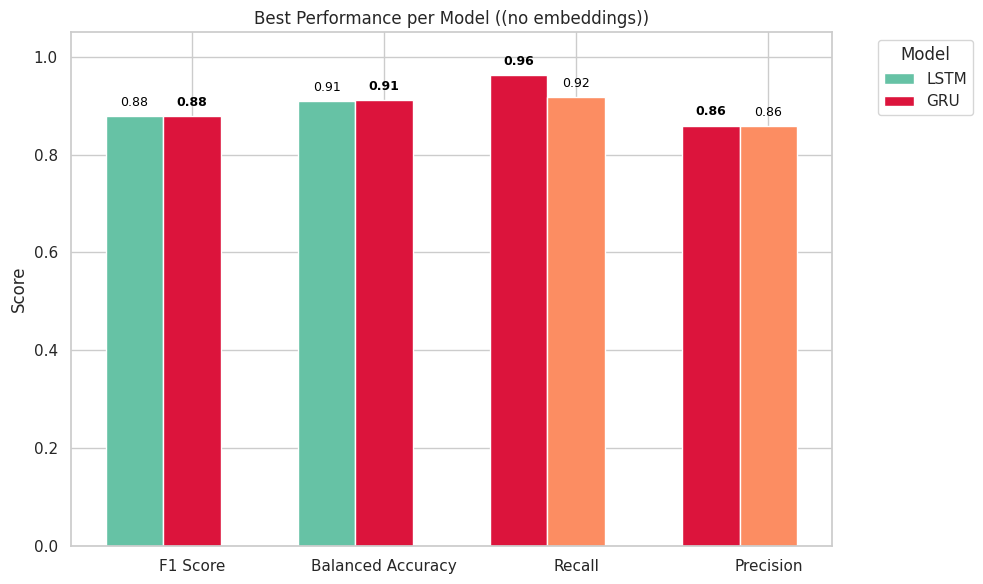

In [16]:
summary_metrics = {
    "Model": [],
    "F1 Score": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": []
}

for model_name, metrics in model_metrics.items():
    summary_metrics["Model"].append(model_name)
    summary_metrics["F1 Score"].append(max(metrics["test_f1s"]))
    summary_metrics["Balanced Accuracy"].append(max(metrics["test_balanced_accs"]))
    summary_metrics["Recall"].append(max(metrics["test_recalls"]))
    summary_metrics["Precision"].append(max(metrics["test_precisions"]))

df_summary = pd.DataFrame(summary_metrics)
df_melted = df_summary.melt(id_vars="Model", var_name="Metric", value_name="Score")

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

models = df_summary["Model"].tolist()
palette = sns.color_palette("Set2", len(models))

# Plotting each metric group
for i, metric in enumerate(df_melted["Metric"].unique()):
    data = df_melted[df_melted["Metric"] == metric]
    max_score = data["Score"].max()

    for j, (index, row) in enumerate(data.iterrows()):
        color = "crimson" if row["Score"] == max_score else palette[models.index(row["Model"])]
        bar = ax.bar(
            x=i - 0.3 + j * (0.6 / len(models)),
            height=row["Score"],
            width=0.6 / len(models),
            color=color,
            label=row["Model"] if i == 0 else "",
        )
        ax.text(
            x=bar[0].get_x() + bar[0].get_width() / 2,
            y=row["Score"] + 0.015,
            s=f"{row['Score']:.2f}",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black',
            fontweight='bold' if row["Score"] == max_score else 'normal'
        )

ax.set_xticks(range(len(df_melted["Metric"].unique())))
ax.set_xticklabels(df_melted["Metric"].unique())
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Best Performance per Model ((no embeddings))")
ax.grid(True, axis='y')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("best_model_performance_comparison_all_values.png")
plt.show()

In [14]:
model_lstm = LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=200, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device)
model_lstm.load_state_dict(torch.load("/content/drive/MyDrive/binary_LSTM_loss_gap_accuracy_gap_5%.pth"))

model_gru = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=200, hidden_dim=350, num_layers=1, dropout_prob=0.8).to(device)
model_gru.load_state_dict(torch.load("/content/drive/MyDrive/binary_GRU_loss_gap_accuracy_gap_5%.pth"))

<All keys matched successfully>

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(ax, y_true, y_pred, num_classes):
    """Plots a confusion matrix as a heatmap.

    Args:
        ax (matplotlib.axes.Axes): The axes on which to plot the confusion matrix.
        y_true (list or array): The true class labels for the test set.
        y_pred (list or array): The predicted class labels for the test set.
        num_classes (int): The number of unique classes in the dataset.
    """
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes), ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')

def evaluate_and_analyze(model, test_loader, device, num_classes=2):
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []
    all_indices = []

    top_correct = []
    top_wrong = []

    with torch.no_grad():
        for idx, (inputs, labels, raw_text) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            if outputs.shape[1] == 1:
                probs = torch.sigmoid(outputs).squeeze(1)
                preds = (probs >= 0.5).long()
            else:
                probs = torch.softmax(outputs, dim=1)[:, 1]
                preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_indices.extend(range(len(labels)))

            correct_indices = (preds == labels).nonzero(as_tuple=True)[0]
            wrong_indices = (preds != labels).nonzero(as_tuple=True)[0]

            for correct_idx in correct_indices:
                top_correct.append({
                    'index': correct_idx.item(),
                    'true_label': labels[correct_idx].item(),
                    'predicted_label': preds[correct_idx].item(),
                    'probability': probs[correct_idx].cpu().item(),
                    'text': raw_text[correct_idx.item()] if raw_text is not None else None
                })

            for wrong_idx in wrong_indices:
                top_wrong.append({
                    'index': wrong_idx.item(),
                    'true_label': labels[wrong_idx].item(),
                    'predicted_label': preds[wrong_idx].item(),
                    'probability': probs[wrong_idx].cpu().item(),
                    'text': raw_text[wrong_idx.item()] if raw_text is not None else None
                })

    df_correct = pd.DataFrame(top_correct)
    df_wrong = pd.DataFrame(top_wrong)

    class_report = classification_report(all_labels, all_preds, output_dict=True)
    df_results = pd.DataFrame(class_report).transpose()

    return df_results, df_correct, df_wrong, all_labels, all_preds

In [16]:
df_results_gru, df_correct_gru, df_wrong_gru, all_labels_gru, all_preds_gru = evaluate_and_analyze(model_gru, test_loader, device)
df_results_lstm, df_correct_lstm, df_wrong_lstm, all_labels_lstm, all_preds_lstm = evaluate_and_analyze(model_lstm, test_loader, device)

In [17]:
df_wrong_gru.head(2)

,index,true_label,predicted_label,probability,text
0,2,0.0,1,0.506467,aim study identify specie antimicrobial suscep...
1,18,1.0,0,0.333954,"parasitic diseases, malaria, require two host ..."


In [22]:
df_wrong_lstm.head(2)

,index,true_label,predicted_label,probability,text
0,2,0.0,1,0.551695,aim study identify specie antimicrobial suscep...
1,19,0.0,1,0.867130,"background schistosomiasis, also known bilharz..."


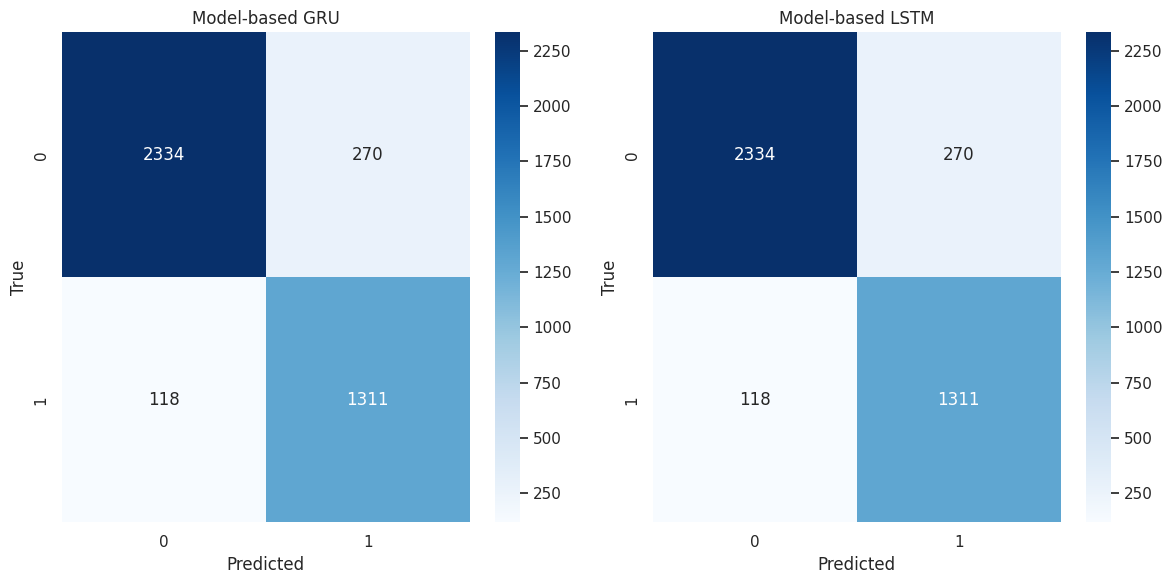

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_confusion_matrix(axes[0], all_labels_gru, all_preds_gru, num_classes = 2)
axes[0].set_title("Model-based GRU")

plot_confusion_matrix(axes[1], all_labels_gru, all_preds_gru, num_classes = 2)
axes[1].set_title("Model-based LSTM")

plt.tight_layout()
plt.show()

In [61]:
from sklearn.metrics import roc_curve, auc

def get_model_probs(model, data_loader, device):
    model.eval()
    probs_list = []
    with torch.no_grad():
        for inputs, labels, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze(1)
            probs_list.extend(probs.cpu().numpy())
    return np.array(probs_list)

In [62]:
all_probs_gru = get_model_probs(model_gru, test_loader, device)
all_probs_lstm = get_model_probs(model_lstm, test_loader, device)

y_true_gru = np.array(all_labels_gru)
y_true_lstm = np.array(all_labels_lstm)

fpr_lstm, tpr_lstm, _ = roc_curve(y_true_lstm, all_probs_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

fpr_gru, tpr_gru, _ = roc_curve(y_true_gru, all_probs_gru)
roc_auc_gru = auc(fpr_gru, tpr_gru)

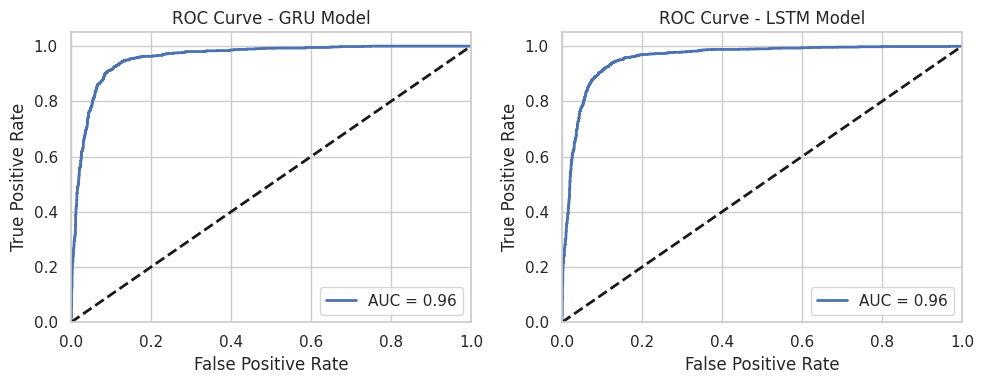

In [64]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(fpr_gru, tpr_gru, lw=2, label=f'AUC = {roc_auc_gru:.2f}')
axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - GRU Model')
axes[0].legend(loc='lower right')
axes[0].grid(True)

axes[1].plot(fpr_lstm, tpr_lstm, lw=2, label=f'AUC = {roc_auc_lstm:.2f}')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - LSTM Model')
axes[1].legend(loc='lower right')
axes[1].grid(True)

plt.tight_layout()
plt.show()

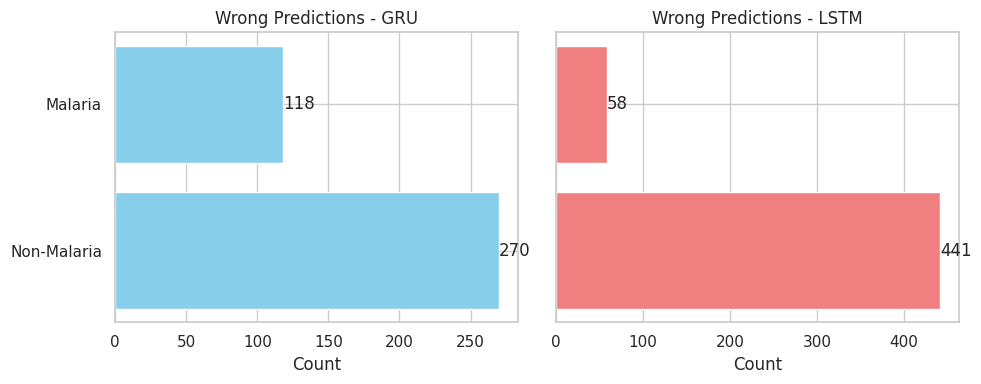

In [66]:
df_wrong_gru['true_label'] = df_wrong_gru['true_label'].astype(int)
df_wrong_lstm['true_label'] = df_wrong_lstm['true_label'].astype(int)

wrong_counts_gru = df_wrong_gru['true_label'].value_counts().sort_index()
wrong_counts_lstm = df_wrong_lstm['true_label'].value_counts().sort_index()

for label in [0, 1]:
    if label not in wrong_counts_gru:
        wrong_counts_gru[label] = 0
    if label not in wrong_counts_lstm:
        wrong_counts_lstm[label] = 0

wrong_counts_gru = wrong_counts_gru.sort_index()
wrong_counts_lstm = wrong_counts_lstm.sort_index()

class_names = ['Non-Malaria', 'Malaria']

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].barh(class_names, wrong_counts_gru.values, color='skyblue')
axes[0].set_title('Wrong Predictions - GRU')
axes[0].set_xlabel('Count')

axes[1].barh(class_names, wrong_counts_lstm.values, color='lightcoral')
axes[1].set_title('Wrong Predictions - LSTM')
axes[1].set_xlabel('Count')

for ax, counts in zip(axes, [wrong_counts_gru, wrong_counts_lstm]):
    for i, count in enumerate(counts.values):
        ax.text(count + 0.2, i, str(count), va='center')

plt.tight_layout()
plt.show()